# Robot Learning - Project 1, Dynamic Movement Primitives

The goal of this project is to use a DMP model to learn a new robot trajectory from the demonstrations that we performed during the lab, which are represented by the cartesian space variables x,y,z and rotational quaternions. With a successful learning model we should be able to show that the trajectory has been learned by adjusting our initial and target positions slightly, and still achieve a working operation.

AI to cite: <br>
ChatGPT 5.2 <br>
Gemini 2.5 Flash <br>
Claude Sonnet 4.5

## Part A. Visualizing the Data

### Initializing the Dataframe

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the directory path (changed to a relative path for standalone project)
directory_path = 'Trajectories/'

# Use glob to find all 'demoX.csv' files
csv_files = glob.glob(os.path.join(directory_path, 'demo*.csv'))

# Initialize an empty list to store individual DataFrames
all_dfs = []

# Loop through each file path
for file_path in csv_files:
    # Extract the 'demo_id' from the filename (e.g., 'demo1')
    file_name = os.path.basename(file_path)
    demo_id = os.path.splitext(file_name)[0] # Removes '.csv' extension

    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Add a new column named 'demo_id' to this DataFrame
    df['demo_id'] = demo_id

    # Append the modified DataFrame to the list of DataFrames
    all_dfs.append(df)

# Concatenate all DataFrames in the list into a single master DataFrame
master_df = pd.concat(all_dfs, ignore_index=True)

# Display the first few rows of the master DataFrame and its information
print(master_df.head()) # Changed display to print
print(master_df.info()) # Changed display to print

                 timestamp         x         y         z        qx        qy  \
0  2026-01-14 21:12:17.933  0.281054  0.909433  0.151313  0.101220  0.987692   
1  2026-01-14 21:12:17.983  0.281662  0.902068  0.143417  0.103394  0.988173   
2  2026-01-14 21:12:18.033  0.282091  0.893652  0.134527  0.105826  0.988673   
3  2026-01-14 21:12:18.083  0.282475  0.885852  0.126564  0.108092  0.989076   
4  2026-01-14 21:12:18.133  0.283019  0.879436  0.120224  0.110114  0.989346   

         qz        qw      roll     pitch       yaw  gripper_cmd_0to1  \
0  0.111673  0.041801  2.910057  0.060001  2.930364               1.0   
1  0.106025  0.039783  2.921705  0.056730  2.926824               1.0   
2  0.099609  0.037468  2.934944  0.053029  2.922829               1.0   
3  0.093788  0.035341  2.946962  0.049654  2.919037               1.0   
4  0.089108  0.033599  2.956620  0.046876  2.915556               1.0   

   gripper_activated gripper_last_action  logging_active demo_id  
0            

### Display One Demonstration

Assuming the CSV contains columns like `x`, `y`, `z`, and quaternion components (e.g., `qx`, `qy`, `qz`, `qw`), I will now generate the plots. If your quaternion columns have different names, please let me know!

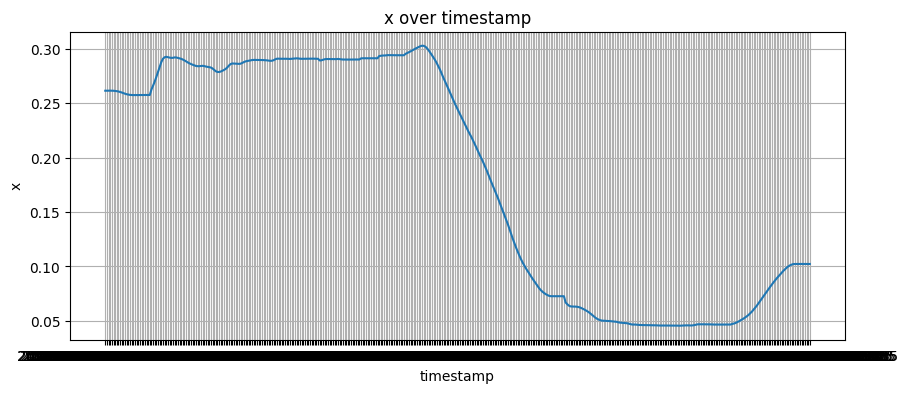

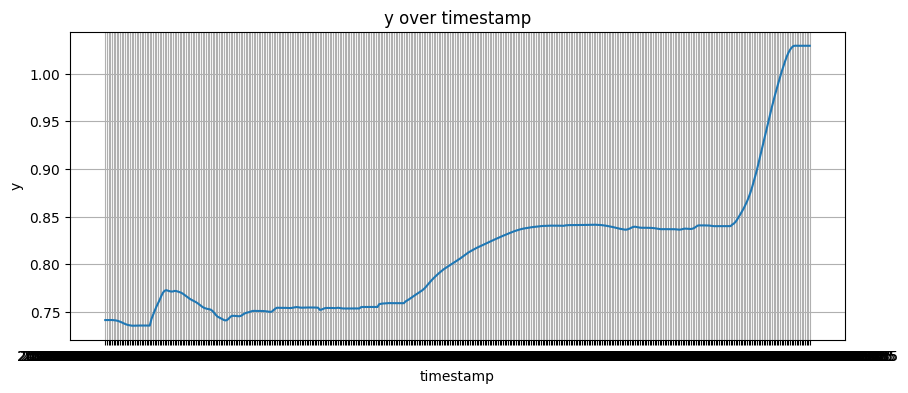

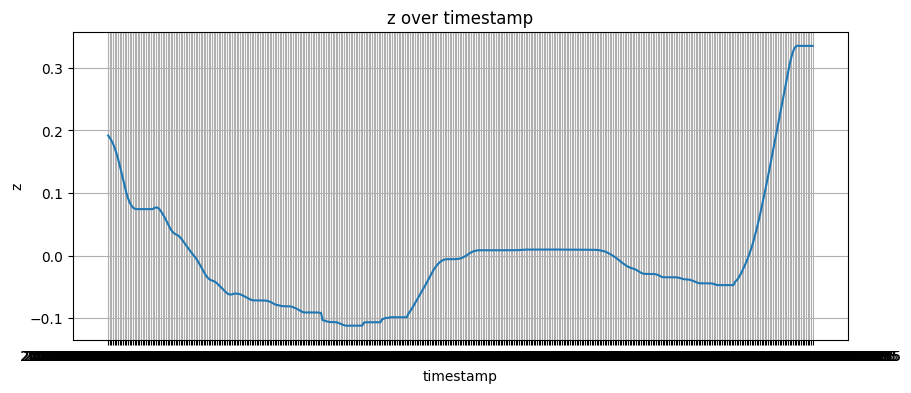

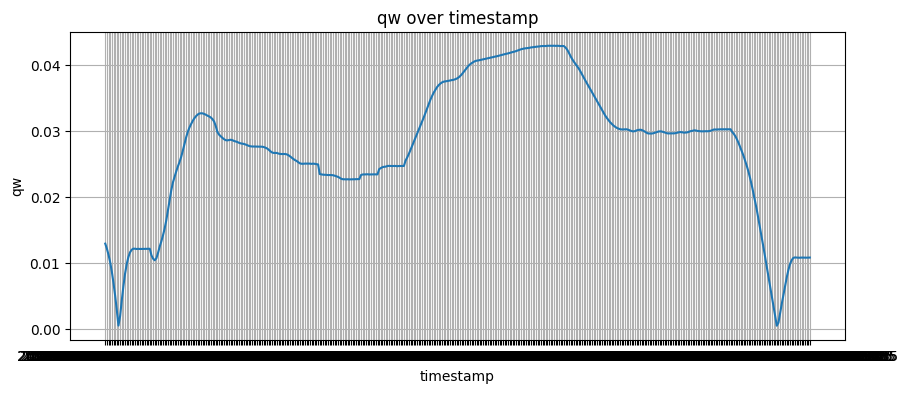

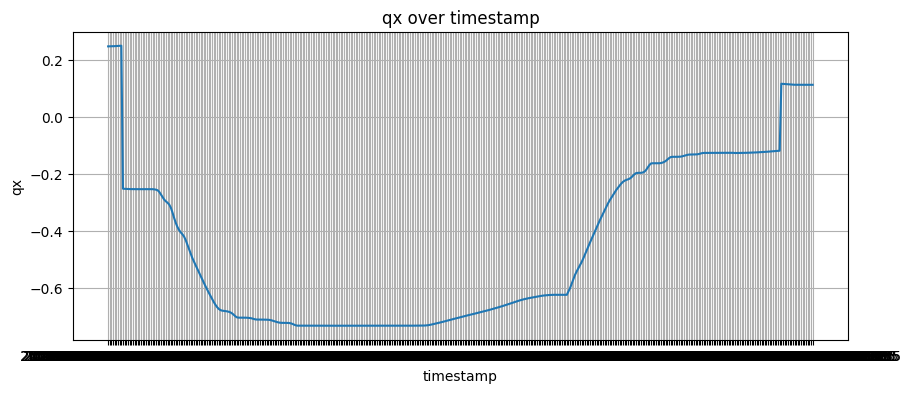

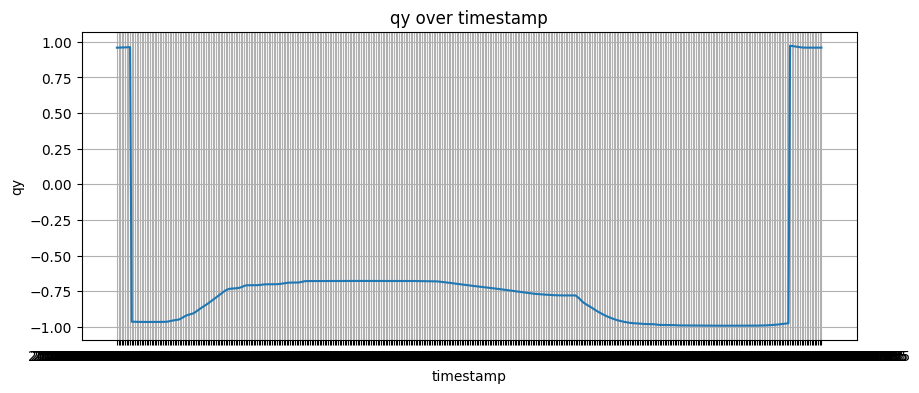

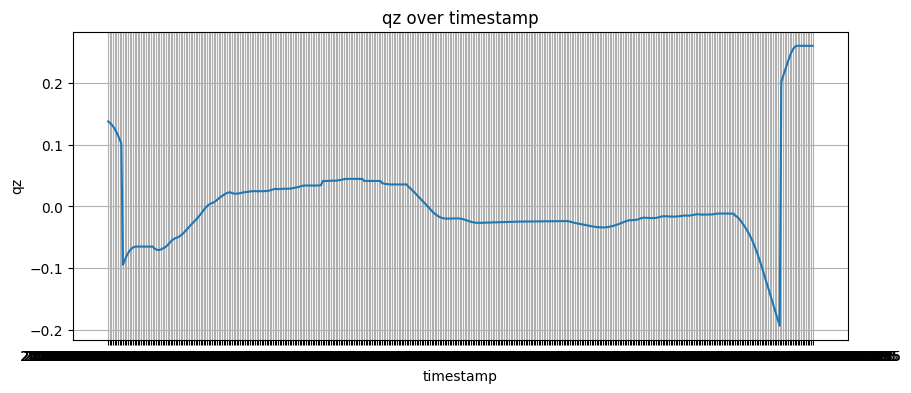

In [2]:
# Select a demonstration to separately visualize
df = master_df[master_df["demo_id"] == "demo8"].copy()

# Identify common quaternion column names if they exist
quaternion_cols = []
if 'qw' in df.columns:
    quaternion_cols.append('qw')
if 'qx' in df.columns:
    quaternion_cols.append('qx')
if 'qy' in df.columns:
    quaternion_cols.append('qy')
if 'qz' in df.columns:
    quaternion_cols.append('qz')

# Prepare columns to plot
columns_to_plot = ['x', 'y', 'z'] + quaternion_cols

# Assuming 'timestep' is the x-axis
x_axis_col = 'timestamp' if 'timestamp' in df.columns else df.columns[0] # Fallback to first column if no 'timestep'

if x_axis_col not in df.columns:
    print(f"Warning: '{x_axis_col}' column not found. Please specify the correct column for the x-axis.")
else:
    for col in columns_to_plot:
        if col in df.columns:
            plt.figure(figsize=(10, 4))
            sns.lineplot(x=df[x_axis_col], y=df[col])
            plt.title(f'{col} over {x_axis_col}')
            plt.xlabel(x_axis_col)
            plt.ylabel(col)
            plt.grid(True)
            plt.savefig(f"figs/{col}.pdf")
            plt.show()
        else:
            print(f"Warning: Column '{col}' not found in the DataFrame. Skipping plot for {col}.")

### Find Local Minima About the Inner Maxima

We estimate the points of interest by finding a local minima in the first 20s of the test, and then a local maxima within 10s-30s, and then finally local minima after that. Visual inspection of the entire data in the following section suggests that this approach will work for every demonstration.

In [3]:
import numpy as np
import pandas as pd

def _to_elapsed_seconds(t_col) -> np.ndarray:
    """
    Convert a time-like series/array to elapsed seconds with T=0 at first sample.
    Handles numeric, datetime64, and datetime strings.
    """
    # Already numeric?
    if np.issubdtype(np.asarray(t_col).dtype, np.number):
        t = np.asarray(t_col, dtype=float)
        return t - t[0]

    s = pd.Series(t_col)

    # If already datetime64
    if np.issubdtype(s.dtype, np.datetime64):
        dt = s
    else:
        # Parse strings to datetime
        dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)

    if dt.isna().any():
        bad = dt.isna().sum()
        raise ValueError(f"Could not parse {bad} timestamp(s) in the time column.")

    t_sec = (dt - dt.iloc[0]).dt.total_seconds().to_numpy(dtype=float)
    return t_sec


def find_extrema_sequence_on_df_z(
    df,
    *,
    time_col: str = "timestep",
    z_col: str = "z",
    t_limit_min1: float = 20.0,
    t_window_max: float = 10.0,
    min_separation_s: float = 0.05,
    min_prominence: float = 0.0,
):
    if time_col not in df.columns:
        time_col = df.columns[0]  # fallback like your plotting code
    if time_col not in df.columns:
        raise ValueError("No valid time column found.")
    if z_col not in df.columns:
        raise ValueError(f"'{z_col}' column not found in the DataFrame.")

    # Convert time to elapsed seconds (T=0 at start)
    t_raw = _to_elapsed_seconds(df[time_col].to_numpy())
    z_raw = df[z_col].to_numpy(dtype=float)

    mask = np.isfinite(t_raw) & np.isfinite(z_raw)
    t = t_raw[mask]
    z = z_raw[mask]

    if t.size < 3:
        return None, None

    # Sort by time and drop duplicate timestamps
    order = np.argsort(t)
    t = t[order]
    z = z[order]

    dt = np.diff(t)
    if np.any(dt <= 0):
        keep = np.ones_like(t, dtype=bool)
        keep[1:] = dt > 0
        t = t[keep]
        z = z[keep]

    if t.size < 3 or np.any(np.diff(t) <= 0):
        raise ValueError("Time must be strictly increasing after cleaning.")

    # --- Local extrema detection ---
    dz = np.gradient(z, t)

    s = np.sign(dz)
    # Fill zeros so sign changes are detectable
    for i in range(1, len(s)):
        if s[i] == 0:
            s[i] = s[i - 1]
    for i in range(len(s) - 2, -1, -1):
        if s[i] == 0:
            s[i] = s[i + 1]

    maxima = np.where((s[:-1] > 0) & (s[1:] < 0))[0] + 1
    minima = np.where((s[:-1] < 0) & (s[1:] > 0))[0] + 1

    def enforce_time_separation(idxs):
        if idxs.size == 0:
            return idxs
        idxs = np.sort(idxs)
        kept = [int(idxs[0])]
        last_t = t[kept[0]]
        for k in idxs[1:]:
            k = int(k)
            if (t[k] - last_t) >= min_separation_s:
                kept.append(k)
                last_t = t[k]
        return np.array(kept, dtype=int)

    maxima = enforce_time_separation(maxima)
    minima = enforce_time_separation(minima)

    # Simple local prominence filter (optional)
    def prominence_ok(idx, is_max, win=10):
        if min_prominence <= 0:
            return True
        lo = max(0, idx - win)
        hi = min(len(z), idx + win + 1)
        neighborhood = z[lo:hi]
        if neighborhood.size < 3:
            return False
        if is_max:
            return (z[idx] - np.min(neighborhood)) >= min_prominence
        else:
            return (np.max(neighborhood) - z[idx]) >= min_prominence

    maxima = np.array([i for i in maxima if prominence_ok(i, True)], dtype=int)
    minima = np.array([i for i in minima if prominence_ok(i, False)], dtype=int)

    # 1) first local minima before 20s: choose the lowest z among minima in that interval
    mins1 = minima[t[minima] < t_limit_min1]
    if mins1.size == 0:
        return None, t
    i_min1 = int(mins1[np.argmin(z[mins1])])

    # Define t0 for the local maxima search as per the comment "between 10s and 30s"
    t0 = 10.0

    # 2) local maxima between 10s and 30s (absolute time)
    maxs = maxima[((t[maxima] > t0) & (t[maxima] <= 30.0))]
    if maxs.size == 0:
        return None, t
    i_max = int(maxs[np.argmax(z[maxs])])


    # 3) local minima after that max
    mins2 = minima[t[minima] > t[i_max]]
    if mins2.size == 0:
        return None, t
    i_min2 = int(mins2[np.argmin(z[mins2])])

    result = {
        "min1": {"idx": i_min1, "t": float(t[i_min1]), "z": float(z[i_min1])},
        "max":  {"idx": i_max,  "t": float(t[i_max]),  "z": float(z[i_max])},
        "min2": {"idx": i_min2, "t": float(t[i_min2]), "z": float(z[i_min2])},
    }
    return result, t

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def to_elapsed_seconds_from_df(df, time_col: str):
    """
    Convert df[time_col] to elapsed seconds (float), with T=0 at first valid sample.
    Handles numeric, datetime64, and datetime strings.
    Returns (t_seconds, valid_mask) where valid_mask marks rows used.
    """
    if time_col not in df.columns:
        time_col = df.columns[0]

    t_series = df[time_col]

    # Numeric case
    if np.issubdtype(t_series.dtype, np.number):
        t = t_series.to_numpy(dtype=float)
        mask = np.isfinite(t)
        t = t[mask]
        t = t - t[0]
        return t, mask

    # Datetime/string case
    dt = pd.to_datetime(t_series, errors="coerce", infer_datetime_format=True)
    mask = dt.notna().to_numpy()

    dt = dt[mask]
    t = (dt - dt.iloc[0]).dt.total_seconds().to_numpy(dtype=float)
    return t, mask


def plot_z_with_extrema(df, result, *, time_col="timestep", z_col="z"):
    """
    Plots z vs elapsed time (T=0 at start) and overlays extrema markers/lines.
    """
    if time_col not in df.columns:
        time_col = df.columns[0]
    if z_col not in df.columns:
        raise ValueError(f"'{z_col}' column not found.")

    # Convert time to elapsed seconds and align z with same valid rows
    t, tmask = to_elapsed_seconds_from_df(df, time_col=time_col)
    z_all = df[z_col].to_numpy(dtype=float)

    # Build aligned mask: must have valid time and valid z
    zmask = np.isfinite(z_all)
    mask = tmask & zmask

    # Apply mask
    z = z_all[mask]

    # NOTE: t returned is only for rows with valid time, but we also filtered by z.
    # So we recompute t again on the already-masked subset for perfect alignment.
    # (Simpler + safer than trying to index-match two masks.)
    df_sub = df.loc[mask, [time_col, z_col]].copy()
    t, _ = to_elapsed_seconds_from_df(df_sub, time_col=time_col)
    z = df_sub[z_col].to_numpy(dtype=float)

    # Sort by time (in case timestamps were out of order)
    order = np.argsort(t)
    t = t[order]
    z = z[order]

    plt.figure(figsize=(10, 4))
    plt.plot(t, z, label="z(t)")
    plt.grid(True)
    plt.xlabel("Time (s) [T=0 at start]")
    plt.ylabel("z")
    plt.title("z(t) with detected extrema")

    if result is not None:
        pts = {
            "Min 1": result["min1"],
            "Max":  result["max"],
            "Min 2": result["min2"],
        }
        # Keep matplotlib defaults for colors if you want; here we set explicit ones.
        colors = {"Min 1": "tab:blue", "Max": "tab:red", "Min 2": "tab:green"}

        for label, p in pts.items():
            plt.scatter(p["t"], p["z"], s=80, color=colors[label], zorder=5)
            plt.axvline(p["t"], color=colors[label], linestyle="--", alpha=0.7)
            plt.annotate(
                f"{label}\n(t={p['t']:.2f}, z={p['z']:.3f})",
                (p["t"], p["z"]),
                textcoords="offset points",
                xytext=(8, 8),
                fontsize=9,
                color=colors[label],
            )

        plt.legend()
    plt.savefig("figs/z-extrema.pdf")
    plt.show()

### Plot the Calculated Extrema

C:\Users\Jaxba\AppData\Local\Temp\ipykernel_14096\326435599.py:21: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
C:\Users\Jaxba\AppData\Local\Temp\ipykernel_14096\2811846443.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(t_series, errors="coerce", infer_datetime_format=True)
C:\Users\Jaxba\AppData\Local\Temp\ipykernel_14096\2811846443.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of

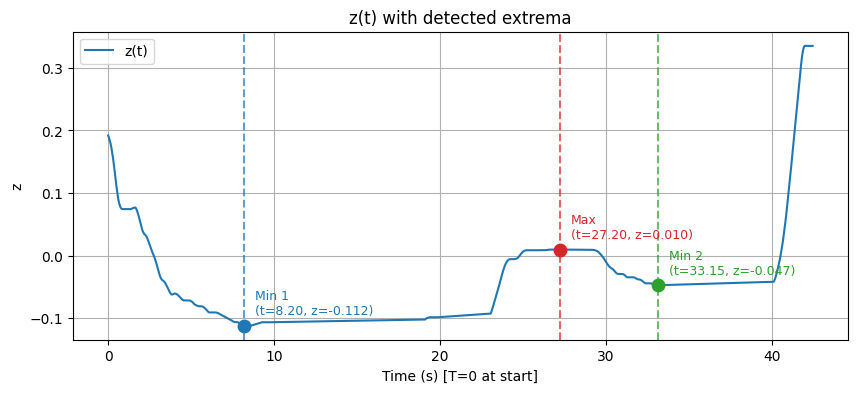

In [5]:
# 1) Run extrema detection on z (timestamps handled, T=0 at start)
result, _ = find_extrema_sequence_on_df_z(
    df,
    time_col="timestep",  # or omit if timestep is the first column
    z_col="z"
)

# 2) Visualize z(t) with extrema overlaid
plot_z_with_extrema(
    df,
    result,
    time_col="timestep",
    z_col="z"
)

### Plot x-y

In [6]:
def plot_xy_trajectory_min1_to_min2(
    df,
    result,
    *,
    time_col="timestep",
    x_col="x",
    y_col="y",
    z_col="z",              # NEW
    save_path=None,
):
    """
    Plot the XY trajectory segment from Min 1 to Min 2 (inclusive),
    using elapsed seconds T=0 at the start of the dataset (after masking/sorting).

    Returns
    -------
    traj_df : pandas.DataFrame
        DataFrame containing elapsed time and x,y,z samples between Min1 and Min2.
    """
    if result is None:
        raise ValueError("result is None (need extrema result with 'min1' and 'min2').")

    for col in (x_col, y_col, z_col):
        if col not in df.columns:
            raise ValueError(f"'{col}' column not found.")

    if time_col not in df.columns:
        time_col = df.columns[0]

    # --- Build a clean, aligned subset with valid time, x, y, z ---
    t_all, tmask = to_elapsed_seconds_from_df(df, time_col=time_col)
    x_all = df[x_col].to_numpy(dtype=float)
    y_all = df[y_col].to_numpy(dtype=float)
    z_all = df[z_col].to_numpy(dtype=float)

    mask = (
        tmask
        & np.isfinite(x_all)
        & np.isfinite(y_all)
        & np.isfinite(z_all)
    )

    df_sub = df.loc[mask, [time_col, x_col, y_col, z_col]].copy()

    # Recompute elapsed time on masked subset
    t, _ = to_elapsed_seconds_from_df(df_sub, time_col=time_col)
    x = df_sub[x_col].to_numpy(dtype=float)
    y = df_sub[y_col].to_numpy(dtype=float)
    z = df_sub[z_col].to_numpy(dtype=float)

    # Sort by time
    order = np.argsort(t)
    t = t[order]
    x = x[order]
    y = y[order]
    z = z[order]

    # --- Determine window [min1, min2] ---
    t1 = float(result["min1"]["t"])
    t2 = float(result["min2"]["t"])
    t_lo, t_hi = (t1, t2) if t1 <= t2 else (t2, t1)

    seg_mask = (t >= t_lo) & (t <= t_hi)
    if not np.any(seg_mask):
        raise ValueError(
            f"No samples found between [{t_lo:.3f}, {t_hi:.3f}] s. "
            "Check time-base alignment."
        )

    # --- Build trajectory DataFrame (NOW INCLUDES z) ---
    traj_df = pd.DataFrame({
        "t": t[seg_mask],
        "x": x[seg_mask],
        "y": y[seg_mask],
        "z": z[seg_mask],
    })

    if save_path is not None:
        traj_df.to_csv(save_path, index=False)

    # --- Plot (XY ONLY, unchanged) ---
    plt.figure(figsize=(6, 6))
    plt.plot(traj_df["x"], traj_df["y"], linewidth=2, label="Trajectory (Min1 → Min2)")
    plt.scatter(traj_df["x"].iloc[0], traj_df["y"].iloc[0], s=80, marker="o", label="Start")
    plt.scatter(traj_df["x"].iloc[-1], traj_df["y"].iloc[-1], s=80, marker="s", label="End")
    plt.grid(True)
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Overhead Plot from Z-minima")
    plt.legend()
    plt.show()

    return traj_df

C:\Users\Jaxba\AppData\Local\Temp\ipykernel_14096\2811846443.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(t_series, errors="coerce", infer_datetime_format=True)
C:\Users\Jaxba\AppData\Local\Temp\ipykernel_14096\2811846443.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(t_series, errors="coerce", infer_datetime_format=True)


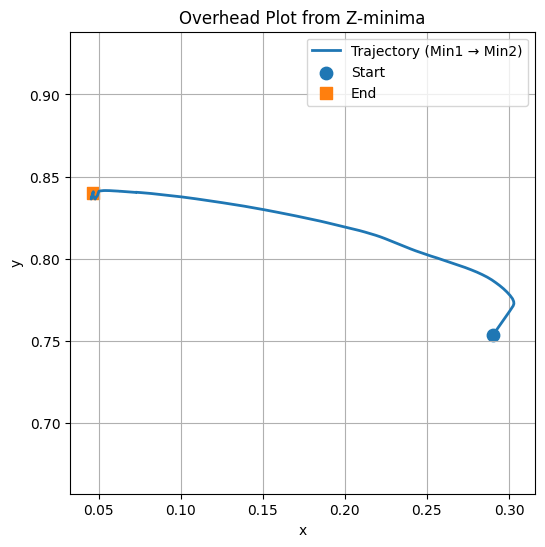

t         x         y         z
0  8.200  0.290257  0.753527 -0.111759
1  8.250  0.290265  0.753510 -0.111753
2  8.300  0.290259  0.753506 -0.111747
3  8.350  0.290302  0.753555 -0.111663
4  8.401  0.290327  0.753569 -0.111650

In [7]:
traj_df = plot_xy_trajectory_min1_to_min2(
    df,
    result,
    time_col="timestep",
    x_col="x",
    y_col="y",
    save_path="min1_to_min2_xy_trajectory.csv",  # optional
)

display(traj_df.head())

### Load All Demo Data

Identify all 'demoX.csv' files in the `Trajectories/` directory, load each into a pandas DataFrame, add a 'demo_id' column to each, and then concatenate them into a single master DataFrame for analysis.


**Reasoning**:
The subtask requires identifying and loading multiple CSV files, adding a 'demo_id' column to each, and then concatenating them into a single master DataFrame. This step will implement all these actions as described in the instructions.



**Reasoning**:
The 'timestamp' column in the `master_df` is currently an object type, which needs to be converted to a datetime object for proper time-series plotting. This conversion is necessary before generating the plots as specified in the main task.



In [8]:
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'])

display(master_df.head())
display(master_df.info())

timestamp         x         y         z        qx        qy  \
0 2026-01-14 21:12:17.933  0.281054  0.909433  0.151313  0.101220  0.987692   
1 2026-01-14 21:12:17.983  0.281662  0.902068  0.143417  0.103394  0.988173   
2 2026-01-14 21:12:18.033  0.282091  0.893652  0.134527  0.105826  0.988673   
3 2026-01-14 21:12:18.083  0.282475  0.885852  0.126564  0.108092  0.989076   
4 2026-01-14 21:12:18.133  0.283019  0.879436  0.120224  0.110114  0.989346   

         qz        qw      roll     pitch       yaw  gripper_cmd_0to1  \
0  0.111673  0.041801  2.910057  0.060001  2.930364               1.0   
1  0.106025  0.039783  2.921705  0.056730  2.926824               1.0   
2  0.099609  0.037468  2.934944  0.053029  2.922829               1.0   
3  0.093788  0.035341  2.946962  0.049654  2.919037               1.0   
4  0.089108  0.033599  2.956620  0.046876  2.915556               1.0   

   gripper_activated gripper_last_action  logging_active demo_id  
0                  0                init               1   demo1  
1                  0                init               1   demo1  
2                  0                init               1   demo1  
3                  0                init               1   demo1  
4                  0                init               1   demo1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937 entries, 0 to 4936
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            4937 non-null   datetime64[ns]
 1   x                    4937 non-null   float64       
 2   y                    4937 non-null   float64       
 3   z                    4937 non-null   float64       
 4   qx                   4937 non-null   float64       
 5   qy                   4937 non-null   float64       
 6   qz                   4937 non-null   float64       
 7   qw                   4937 non-null   float64       
 8   roll                 4937 non-null   float64       
 9   pitch                4937 non-null   float64       
 10  yaw                  4937 non-null   float64       
 11  gripper_cmd_0to1     4937 non-null   float64       
 12  gripper_activated    4937 non-null   int64         
 13  gripper_last_action  4937 non-nul

None

**Reasoning**:
Now that the master DataFrame is prepared and the 'timestamp' column is in the correct format, the next step is to generate the combined line plots for the specified columns ('x', 'y', 'z', 'qw', 'qx', 'qy', 'qz') across all demos, as required by the task. Each demo will be color-coded, and a legend will be added to distinguish them.



### Normalize Timestamps and Remove Bad Trajectories

Create a new column `normalized_timestamp` in the `master_df`. This column will represent the time elapsed from the start of each individual demo, effectively making all demos start at time 0 for plotting purposes.


**Reasoning**:
To normalize the timestamps for each demo, I need to calculate the elapsed time from the start of each individual demo. This involves grouping the DataFrame by 'demo_id', finding the minimum timestamp for each group, and then subtracting this minimum from all timestamps within that group to create the new 'normalized_timestamp' column. Finally, I'll display the head of the DataFrame to verify the new column.



In [9]:
exclude_demos = ['demo7', 'demo9', 'demo10']

# (Optional but highly recommended) normalize demo_id formatting so matching works
master_df['demo_id'] = master_df['demo_id'].astype(str).str.strip().str.lower()

exclude_demos = [d.strip().lower() for d in exclude_demos]

# Ensure timestamp is datetime
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'])

# Build mask
mask = ~master_df['demo_id'].isin(exclude_demos)

# Initialize column as NaN so excluded demos stay empty
master_df['normalized_timestamp'] = np.nan

# Compute on filtered subset only
tmp = master_df.loc[mask].copy()
tmp['normalized_timestamp'] = (
    tmp.groupby('demo_id')['timestamp']
       .transform(lambda x: x - x.min())
       .dt.total_seconds()
)

# Assign back by index (guaranteed alignment)
master_df.loc[tmp.index, 'normalized_timestamp'] = tmp['normalized_timestamp']

# Sanity check: excluded demos should be all NaN
print(master_df.loc[~mask, ['demo_id', 'normalized_timestamp']].head(10))

    demo_id  normalized_timestamp
659  demo10                   NaN
660  demo10                   NaN
661  demo10                   NaN
662  demo10                   NaN
663  demo10                   NaN
664  demo10                   NaN
665  demo10                   NaN
666  demo10                   NaN
667  demo10                   NaN
668  demo10                   NaN


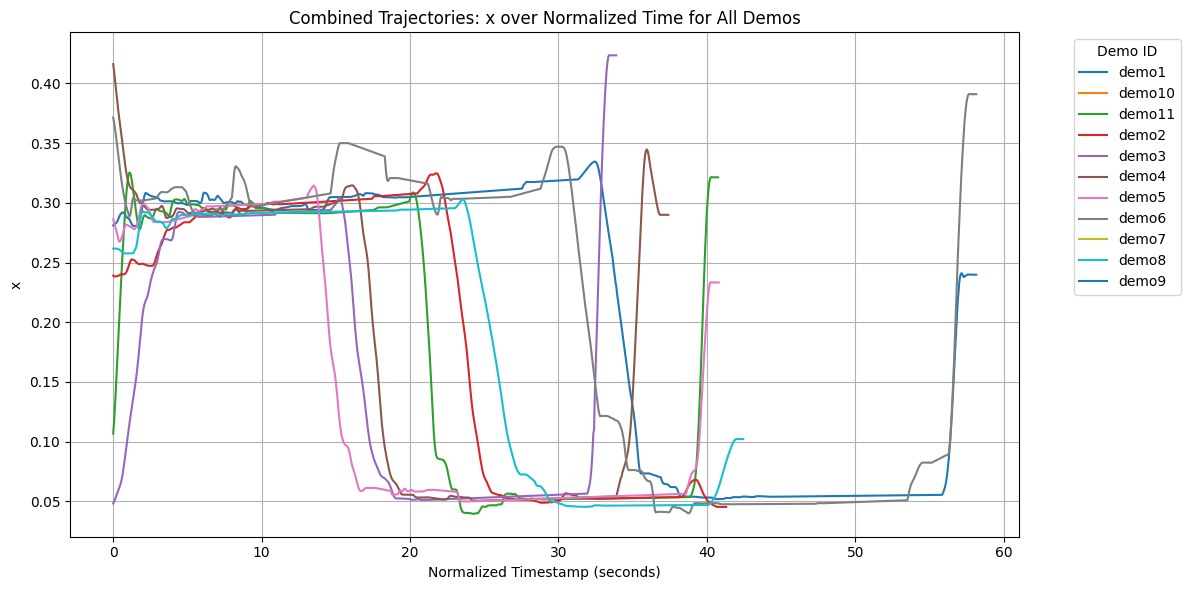

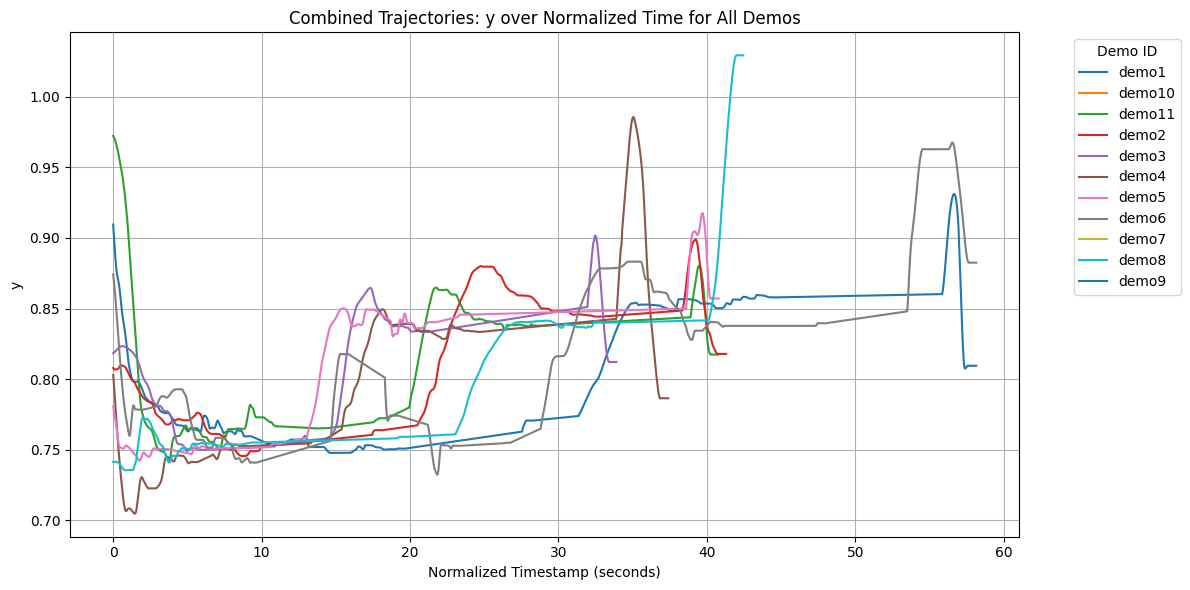

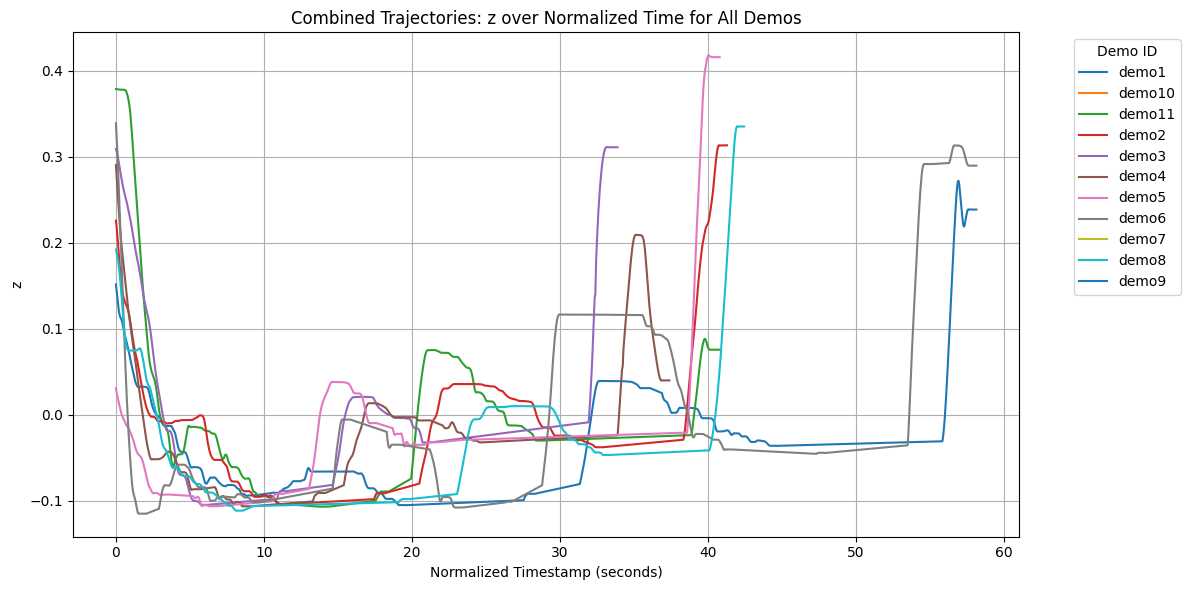

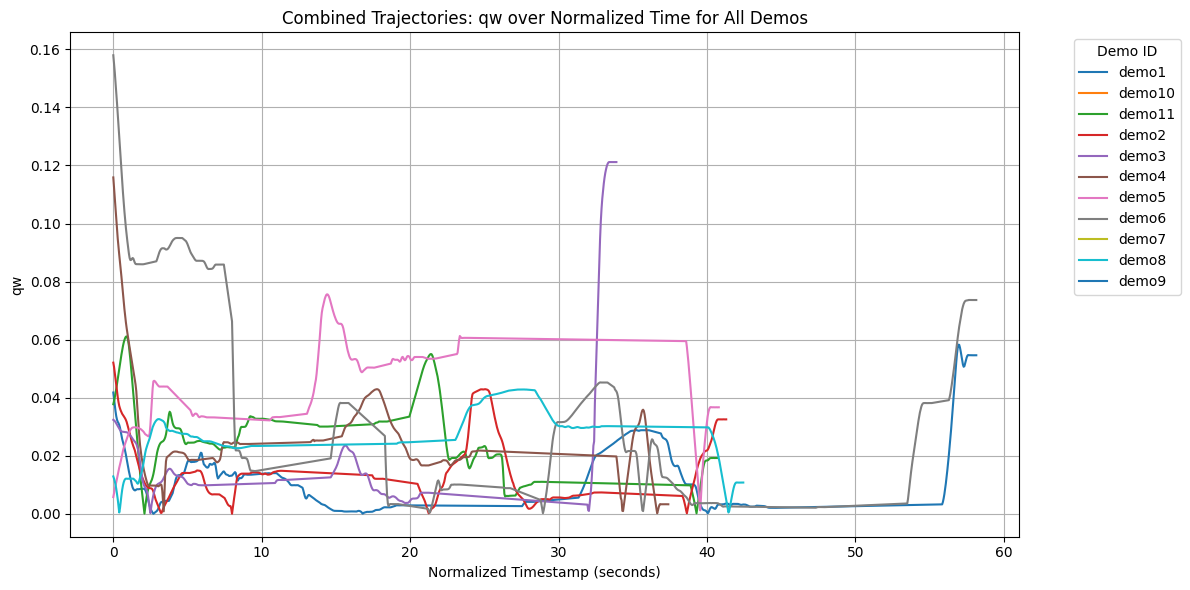

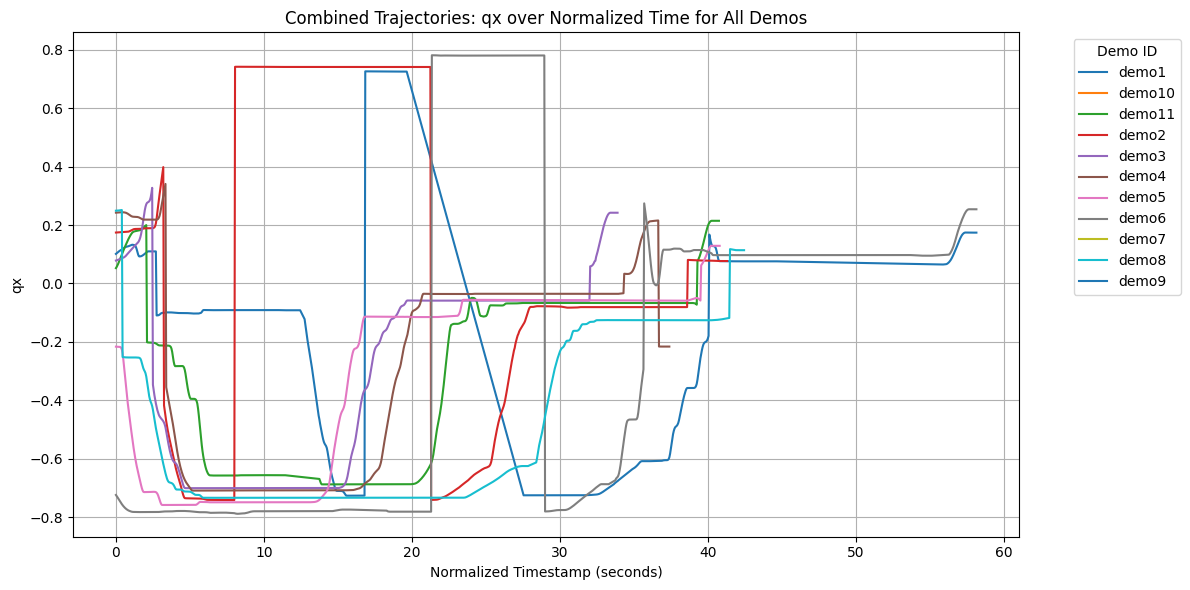

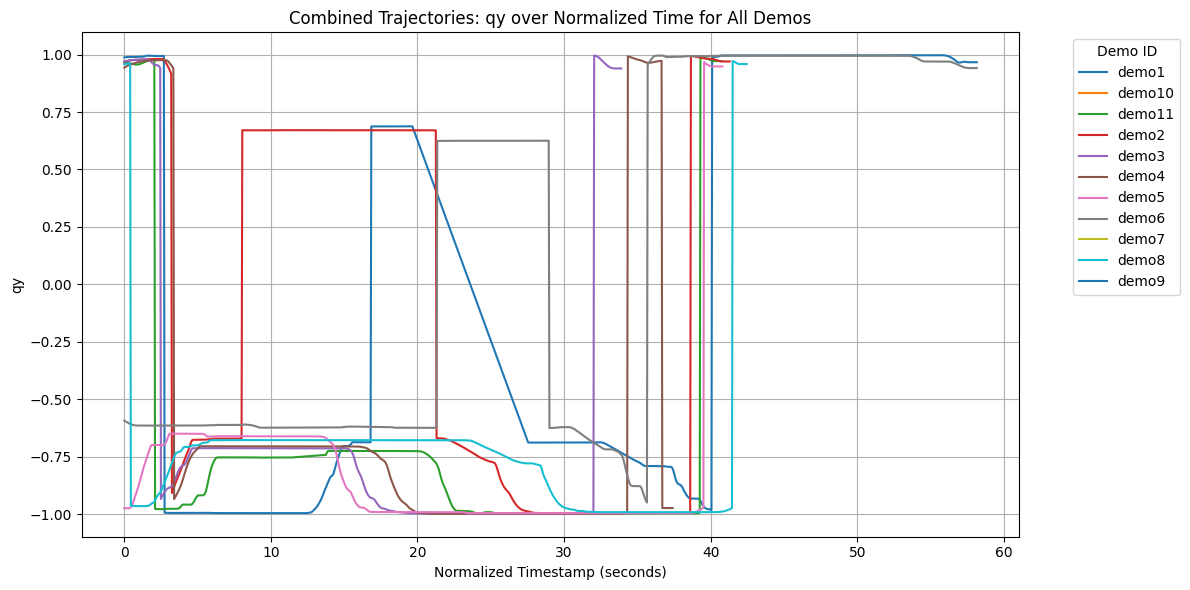

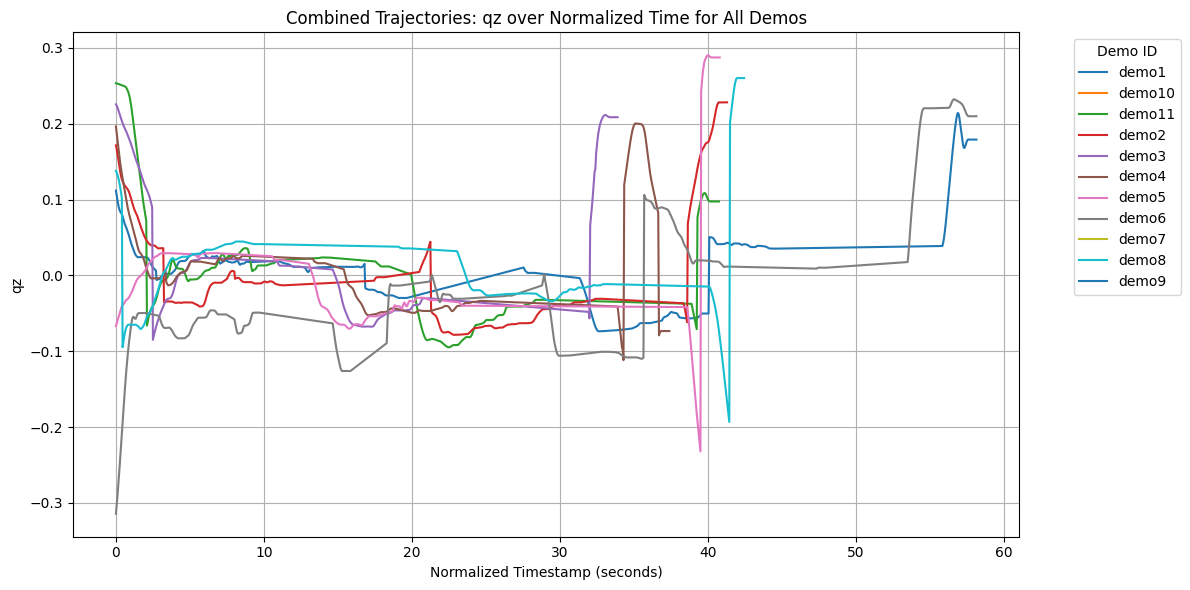

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Columns to plot
plot_columns = ['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz']

# Create a figure for each column to plot
for col in plot_columns:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=master_df, x='normalized_timestamp', y=col, hue='demo_id', palette='tab10')
    plt.title(f'Combined Trajectories: {col} over Normalized Time for All Demos')
    plt.xlabel('Normalized Timestamp (seconds)')
    plt.ylabel(col)
    plt.legend(title='Demo ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    if col == "z":
        plt.savefig("figs/allz.pdf")
    plt.show()

### Part 1. Summary

For each of the seven variables 'x', 'y', 'z', 'qw', 'qx', 'qy', and 'qz', a separate graph is displayed, showing its values over time (`normalized_timestamp`) for all available demos. Each `demo_id` is distinctly color-coded within the plots, and a legend is provided to identify which color corresponds to which demo. This confirms that the x, y, z, and quaternion values for all 10 identified demos are displayed on individual graphs and are appropriately color-coded, fulfilling the requirements of the task.


The x, y, z, and quaternion values (qw, qx, qy, qz) for all 10 identified demos were successfully displayed on individual graphs. Each `demo_id` was distinctly color-coded within the plots, and a legend was provided to identify which color corresponds to which demo, fulfilling the task requirements.

*   All `demoX.csv` files were successfully identified and loaded, resulting in a master DataFrame (`master_df`) with 4542 entries and 16 columns.
*   A `demo_id` column was accurately added to each individual DataFrame before concatenation, indicating the source demo (e.g., 'demo6'), with the bad data set to NaN
*   The `timestamp` column was successfully converted from an `object` data type to `datetime64[ns]`, enabling proper time-series analysis.
*   Extrema were estimated and added to the z-plot
*   A new column, `normalized_timestamp`, was added to the `master_df` by grouping the DataFrame by `demo_id` and subtracting the minimum `timestamp` from all `timestamp` values within each group, effectively setting the start time of each demo to `0`.
*   Seven individual line plots were generated, one for each specified column ('x', 'y', 'z', 'qw', 'qx, 'qy', 'qz'), using `normalized_timestamp` as the x-axis.
*   Each plot effectively used the `demo_id` column to color-code the different demos, and a legend was included to clearly identify each demo's trajectory.

## Part B. Applying the DMP


https://github.com/AlexanderFabisch/PyDMP/blob/master/DMP.ipynb


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from dmp import DMP  # your local dmp.py

def imitate_fixed_goal_force_units(dmp, X, tau, n_bfs, ridge_alpha=1e-6):
    """
    Like dmp.imitate(), but fixes g and returns w that matches the 'F' definition
    used in your file (force-like units).
    """
    n_steps, n_dims = X.shape
    dt = tau / float(n_steps - 1)

    x0 = X[0]
    g  = X[-1]

    Xd  = np.vstack((np.zeros((1, n_dims)), np.diff(X, axis=0) / dt))
    Xdd = np.vstack((np.zeros((1, n_dims)), np.diff(Xd, axis=0) / dt))

    # Force-like target from your file :contentReference[oaicite:4]{index=4}
    F = tau * tau * Xdd - dmp.alpha * (dmp.beta * (g - X) - tau * Xd)

    design = np.array([dmp._features(tau, n_bfs, s) for s in dmp.phase(n_steps)])  # :contentReference[oaicite:5]{index=5}

    lr = Ridge(alpha=ridge_alpha, fit_intercept=False)
    lr.fit(design, F)
    w = lr.coef_  # (n_dims, n_bfs)
    return w, x0, g

def trajectory_tau_scaled(dmp, w, x0, g, tau, dt, shape=True):
    """
    Same as your trajectory(), but uses f/tau^2 so the learned weights actually shape.
    """
    x = x0.copy().astype(float)
    xd = np.zeros_like(x)
    xdd = np.zeros_like(x)

    X = [x.copy()]

    internal_dt = min(0.001, dt)
    n_internal_steps = int(tau / internal_dt)
    steps_between_measurement = int(dt / internal_dt)

    t = 0.5 * internal_dt
    ti = 0
    S = dmp.phase(n_internal_steps + 1)

    while t < tau:
        t += internal_dt
        ti += 1
        s = S[ti]

        x += internal_dt * xd
        xd += internal_dt * xdd

        sd = dmp.spring_damper(x0, g, tau, s, x, xd)
        f  = dmp.forcing_term(x0, g, tau, w, s, x) if shape else 0.0
        xdd = sd + (f / (tau ** 2))

        if ti % steps_between_measurement == 0:
            X.append(x.copy())

    return np.array(X)


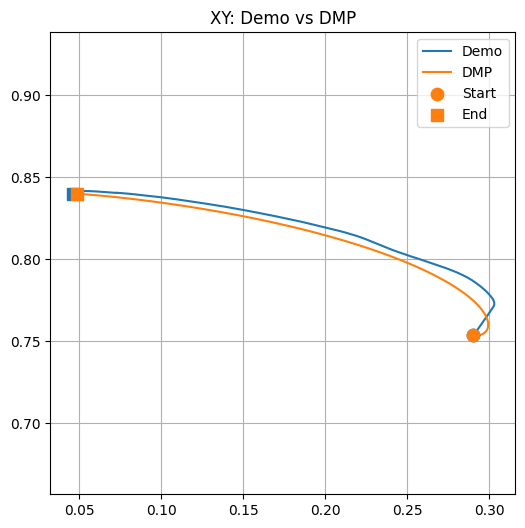

In [12]:
# Build demo array (N,2)
X_demo = traj_df[["x","y"]].to_numpy(dtype=float)
t = traj_df["t"].to_numpy(dtype=float)
order = np.argsort(t)
t = t[order]
X_demo = X_demo[order]

tau = float(t[-1] - t[0])

dmp = DMP(pastor_mod=False)
w, x0, g = imitate_fixed_goal_force_units(dmp, X_demo, tau, n_bfs=50, ridge_alpha=1e-6)

X_gen = trajectory_tau_scaled(dmp, w, x0, g, tau, dt=0.01, shape=True)

plt.figure(figsize=(6, 6))

# ---- Demo trajectory ----
line_demo, = plt.plot(X_demo[:, 0], X_demo[:, 1], label="Demo")
demo_color = line_demo.get_color()

plt.scatter(
    X_demo[0, 0], X_demo[0, 1],
    color=demo_color, marker="o", s=80, zorder=3,
)
plt.scatter(
    X_demo[-1, 0], X_demo[-1, 1],
    color=demo_color, marker="s", s=80, zorder=3,
)

# ---- DMP trajectory ----
line_gen, = plt.plot(X_gen[:, 0], X_gen[:, 1], label="DMP")
gen_color = line_gen.get_color()

plt.scatter(
    X_gen[0, 0], X_gen[0, 1],
    color=gen_color, marker="o", s=80, zorder=3,
    label="Start"
)
plt.scatter(
    X_gen[-1, 0], X_gen[-1, 1],
    color=gen_color, marker="s", s=80, zorder=3,
    label="End"
)

plt.axis("equal")
plt.grid(True)
plt.legend()
plt.title("XY: Demo vs DMP")
plt.savefig("figs/dmp.pdf")
plt.show()


### Testing on Shifted points

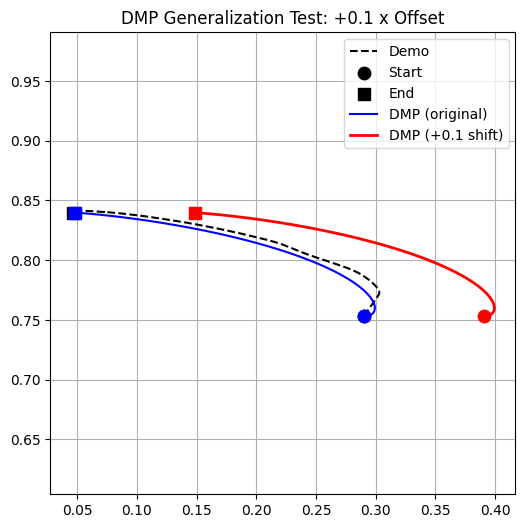

In [13]:
# Original start / goal
x0_orig = x0.copy()
g_orig  = g.copy()

# Shift +0.1
delta = 0.1
x0_shift = x0_orig + np.array([delta, 0])
g_shift  = g_orig  + np.array([delta, 0])

X_gen_shifted = trajectory_tau_scaled(
    dmp,
    w,
    x0_shift,
    g_shift,
    tau,
    dt=0.01,
    shape=True
)

plt.figure(figsize=(6, 6))

# ---- Demo (black dashed) ----
line_demo, = plt.plot(X_demo[:, 0], X_demo[:, 1], 'k--', label="Demo")
demo_color = line_demo.get_color()

plt.scatter(
    X_demo[0, 0], X_demo[0, 1],
    color=demo_color, marker="o", s=80, zorder=3,
    label="Start"
)
plt.scatter(
    X_demo[-1, 0], X_demo[-1, 1],
    color=demo_color, marker="s", s=80, zorder=3,
    label="End"
)

# ---- DMP (original, blue) ----
line_gen, = plt.plot(X_gen[:, 0], X_gen[:, 1], 'b', label="DMP (original)")
gen_color = line_gen.get_color()

plt.scatter(
    X_gen[0, 0], X_gen[0, 1],
    color=gen_color, marker="o", s=80, zorder=3,
)
plt.scatter(
    X_gen[-1, 0], X_gen[-1, 1],
    color=gen_color, marker="s", s=80, zorder=3,
)

# ---- Shifted DMP (+0.1, red) ----
line_shifted, = plt.plot(
    X_gen_shifted[:, 0], X_gen_shifted[:, 1],
    'r', linewidth=2, label="DMP (+0.1 shift)"
)
shift_color = line_shifted.get_color()

plt.scatter(
    X_gen_shifted[0, 0], X_gen_shifted[0, 1],
    color=shift_color, marker="o", s=80, zorder=3,
)
plt.scatter(
    X_gen_shifted[-1, 0], X_gen_shifted[-1, 1],
    color=shift_color, marker="s", s=80, zorder=3,
)

plt.axis("equal")
plt.grid(True)
plt.legend()
plt.title("DMP Generalization Test: +0.1 x Offset")
plt.savefig("figs/x-offset.pdf")
plt.show()



## Part C. Dynamic Time Warping

https://dynamictimewarping.github.io/

### Calculating Extrema and X-Y for All Trajectories

  demo_id  timestep
0   demo1       NaN
1   demo1       NaN
2   demo1       NaN
3   demo1       NaN
4   demo1       NaN
5   demo1       NaN
6   demo1       NaN
7   demo1       NaN
8   demo1       NaN
9   demo1       NaN

===== DEMO: demo11 =====


<Figure size 1000x800 with 0 Axes>

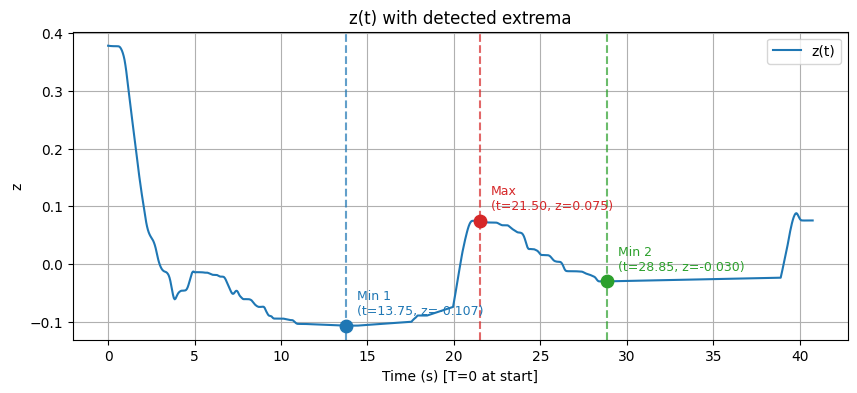

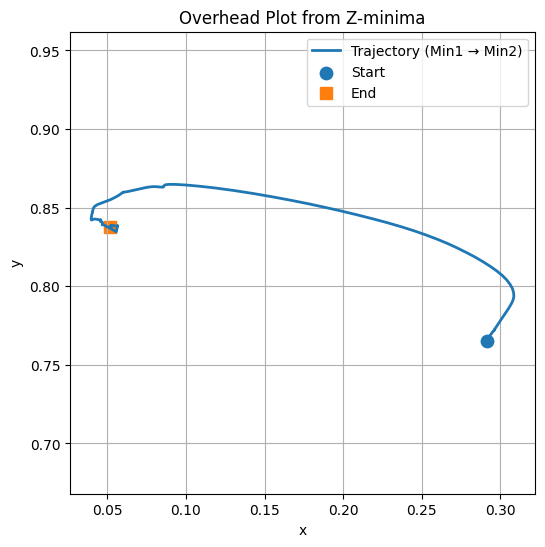


===== DEMO: demo2 =====


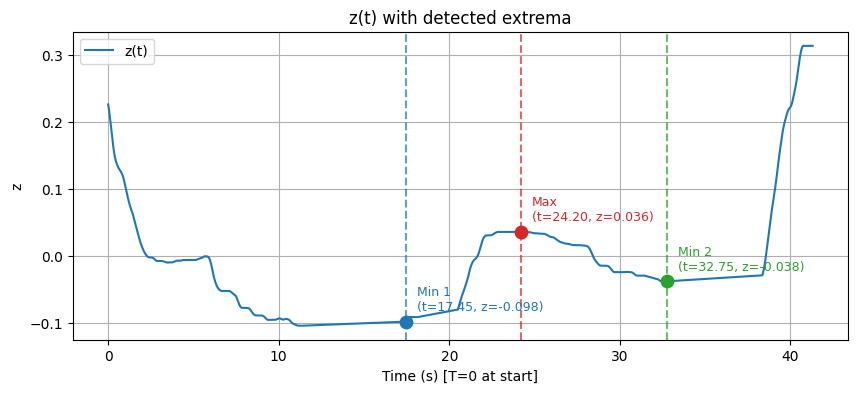

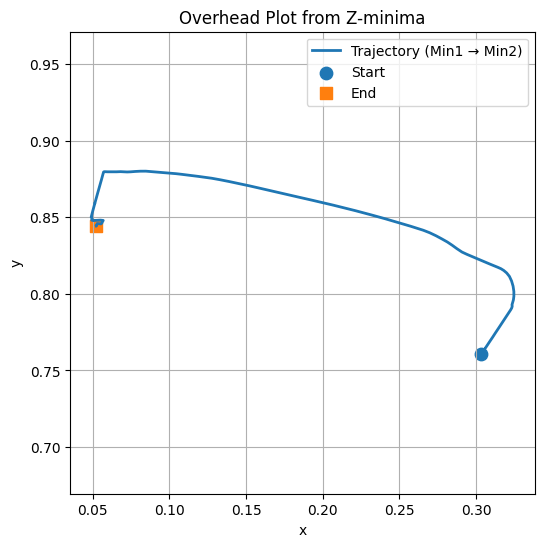


===== DEMO: demo3 =====


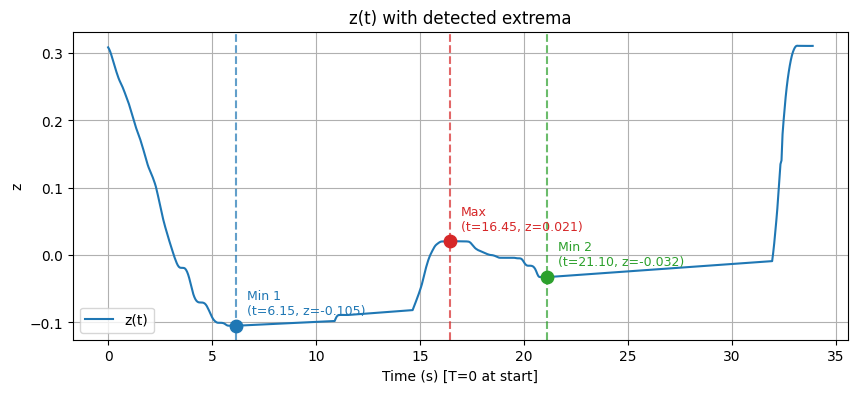

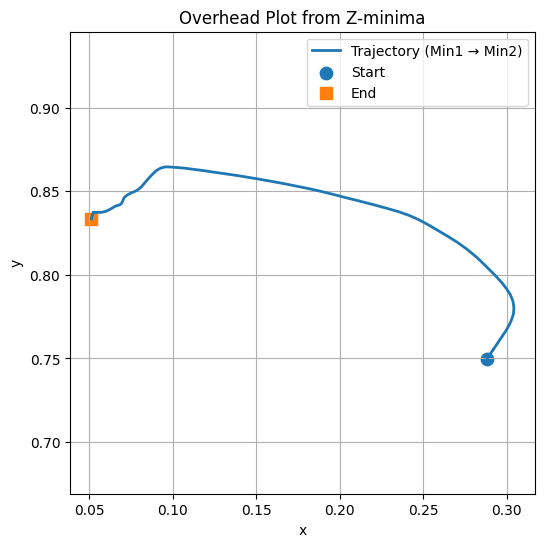


===== DEMO: demo4 =====


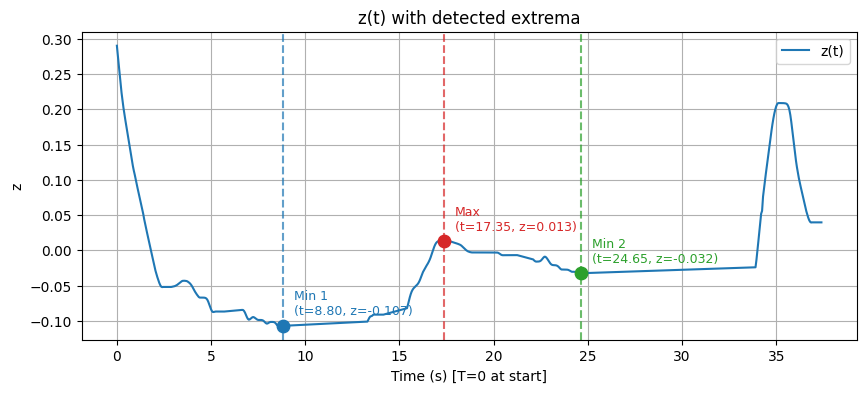

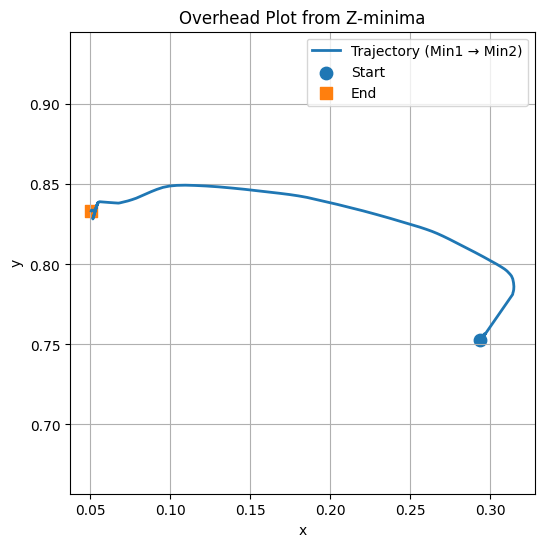


===== DEMO: demo5 =====


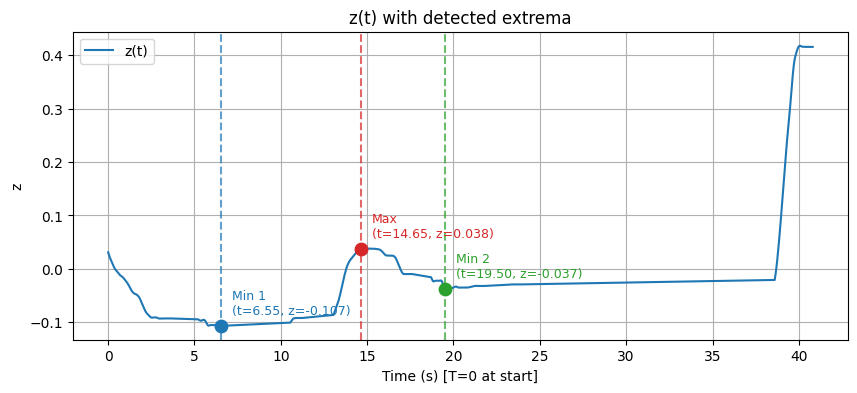

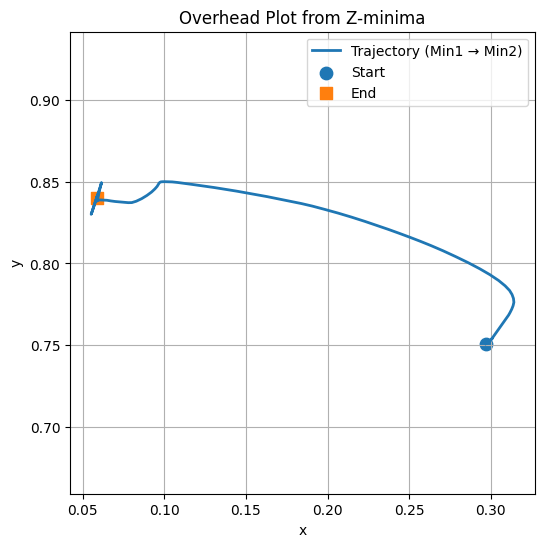


===== DEMO: demo8 =====


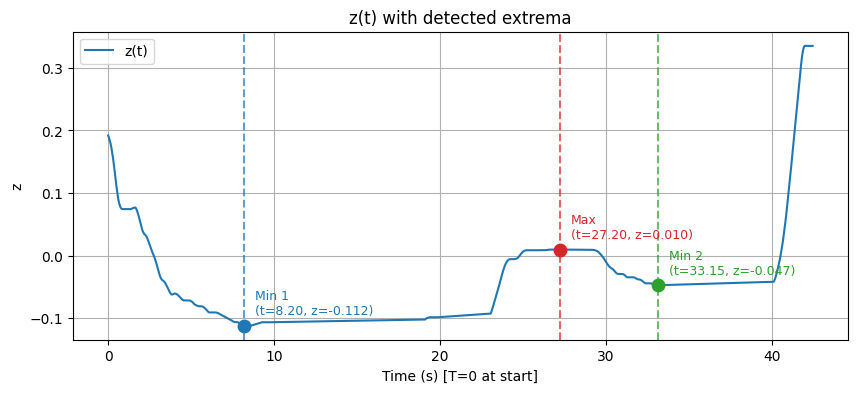

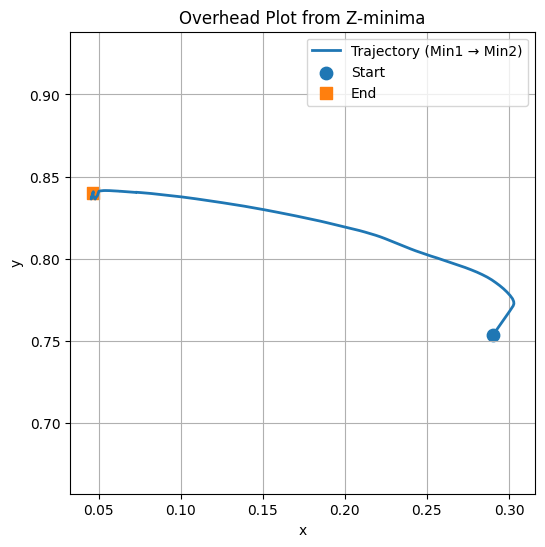

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# If you still want seaborn styling, keep this import; otherwise you can remove it.
import seaborn as sns

exclude_demos = ['demo6', 'demo1', 'demo7', 'demo9', 'demo10']

# --- Normalize demo_id formatting so matching works ---
master_df['demo_id'] = master_df['demo_id'].astype(str).str.strip().str.lower()
exclude_demos = [d.strip().lower() for d in exclude_demos]

# --- Ensure timestamp is datetime ---
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'])

# --- Mask out excluded demos ---
mask = ~master_df['demo_id'].isin(exclude_demos)

# --- Create normalized time (seconds from each demo start) ONLY for included demos ---
master_df['timestep'] = np.nan  # we'll use this as time_col for your extrema/plot functions

tmp = master_df.loc[mask].copy()
tmp['timestep'] = (
    tmp.groupby('demo_id')['timestamp']
       .transform(lambda x: (x - x.min()).dt.total_seconds())
)

master_df.loc[tmp.index, 'timestep'] = tmp['timestep']

# Sanity check: excluded demos should be all NaN
print(master_df.loc[~mask, ['demo_id', 'timestep']].head(10))

# --- For each demo, call find_extrema_sequence_on_df_z(), then plot the x-y segment min1->min2 ---
xy_segments = {}  # demo_id -> traj_df (segment)

included_demo_ids = (
    master_df.loc[mask, 'demo_id']
             .dropna()
             .unique()
)

plt.figure(figsize=(10, 8))

for demo_id in included_demo_ids:
    df = master_df.loc[mask & (master_df['demo_id'] == demo_id), ['timestep', 'x', 'y', 'z']].copy()

    # Drop rows missing essentials
    df = df.dropna(subset=['timestep', 'x', 'y', 'z'])

    # Sort by time (important)
    df = df.sort_values('timestep').reset_index(drop=True)

    if len(df) < 5:
        print(f"Skipping {demo_id}: not enough valid samples ({len(df)})")
        continue

    print(f"\n===== DEMO: {demo_id} =====")
    
    # ---- 1) Find extrema sequence on z (min1 -> max -> min2, etc., depending on your function) ----
    result, _ = find_extrema_sequence_on_df_z(
        df,
        time_col="timestep",
        z_col="z"
    )
    plot_z_with_extrema(
        df,
        result,
        time_col="timestep",
        z_col="z"
    )

    # ---- 2) Extract and (optionally) save the x-y trajectory segment min1->min2 ----
    # NOTE: save_path is optional; if you want unique per demo, use a demo-specific filename.
    traj_df = plot_xy_trajectory_min1_to_min2(
        df,
        result,
        time_col="timestep",
        x_col="x",
        y_col="y",
        save_path=None  # or f"{demo_id}_min1_to_min2_xy_trajectory.csv"
    )

    xy_segments[demo_id] = traj_df


### Plot All X-Y from Extrema

In [15]:
import pandas as pd
import numpy as np

all_traj_rows = []
missing_time = []

for demo_id, traj_df in xy_segments.items():
    if traj_df is None or len(traj_df) == 0:
        continue

    df = traj_df.copy()

    # ---- 1) pick an existing time column, if any ----
    time_col = None
    for cand in ['t', 'timestep', 'timestamp', 'normalized_timestamp', 'time']:
        if cand in df.columns:
            time_col = cand
            break

    # ---- 2) if none exists, create one ----
    if time_col is None:
        missing_time.append(demo_id)
        df['t'] = np.arange(len(df), dtype=float)
        time_col = 't'

    # ---- 3) if time is a timestamp, convert to elapsed seconds ----
    if time_col == 'timestamp':
        ts = pd.to_datetime(df[time_col], errors='coerce')
        df['t'] = (ts - ts.iloc[0]).dt.total_seconds()
    else:
        # rename chosen time col to 't' if it's not already
        if time_col != 't':
            df = df.rename(columns={time_col: 't'})

        # ensure numeric float time
        df['t'] = pd.to_numeric(df['t'], errors='coerce')

    # drop rows with bad t/x/y
    df = df.dropna(subset=['t', 'x', 'y'])

    # sort by time
    df = df.sort_values('t')

    df['demo_id'] = demo_id
    all_traj_rows.append(df[['demo_id', 't', 'x', 'y', 'z']])

all_traj_df = pd.concat(all_traj_rows, ignore_index=True)

print("Combined shape:", all_traj_df.shape)
print("Demos missing an explicit time column (used index-based t):", missing_time)
display(all_traj_df.head())


Combined shape: (1150, 5)
Demos missing an explicit time column (used index-based t): []


demo_id      t         x         y         z
0  demo11  13.75  0.291248  0.765103 -0.107149
1  demo11  13.80  0.291196  0.765128 -0.107113
2  demo11  13.85  0.291199  0.765157 -0.107109
3  demo11  13.90  0.291147  0.765172 -0.107094
4  demo11  13.95  0.291135  0.765180 -0.107117

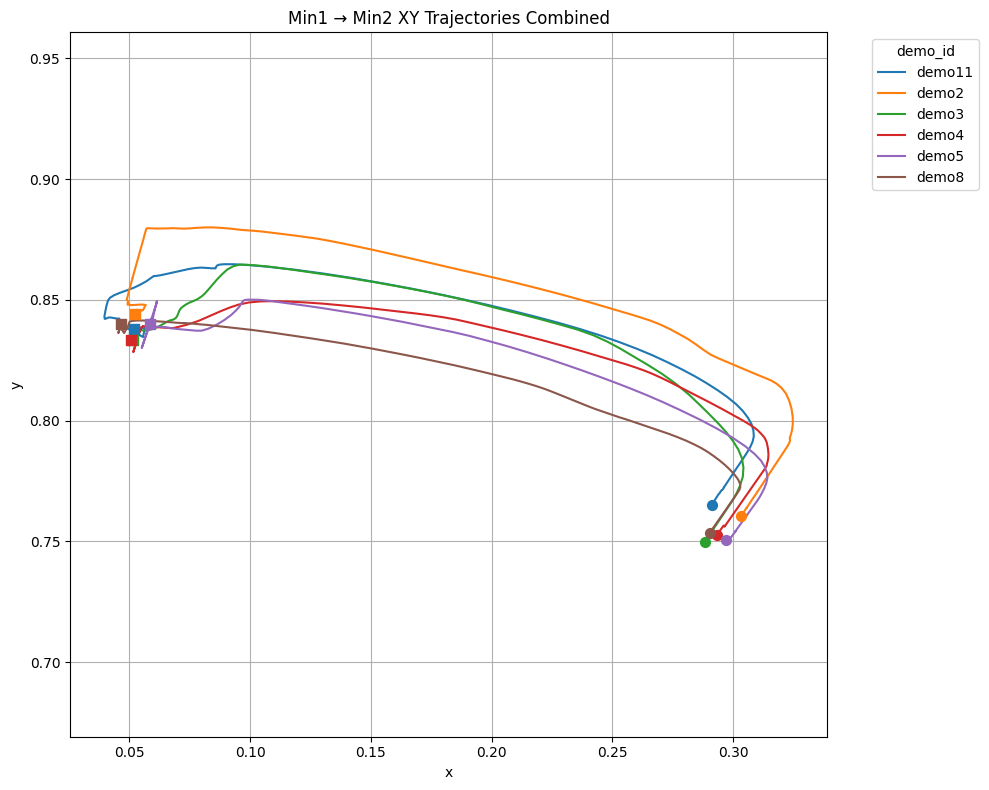

In [16]:
plt.figure(figsize=(10, 8))

for demo_id, traj_df in xy_segments.items():
    # safety: skip empties
    if traj_df is None or len(traj_df) == 0:
        continue

    # ensure ordered
    if 'timestep' in traj_df.columns:
        traj_df = traj_df.sort_values('timestep')

    x = traj_df['x'].to_numpy()
    y = traj_df['y'].to_numpy()

    # ---- plot trajectory and capture color ----
    line, = plt.plot(x, y, label=demo_id)
    color = line.get_color()

    # ---- start marker (circle) ----
    plt.scatter(
        x[0], y[0],
        marker='o',
        s=50,
        color=color,
        zorder=5
    )

    # ---- end marker (square) ----
    plt.scatter(
        x[-1], y[-1],
        marker='s',
        s=60,
        color=color,
        zorder=5
    )

plt.title("Min1 → Min2 XY Trajectories Combined")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)

plt.legend(
    title="demo_id",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.savefig("figs/alltraj.pdf")
plt.show()


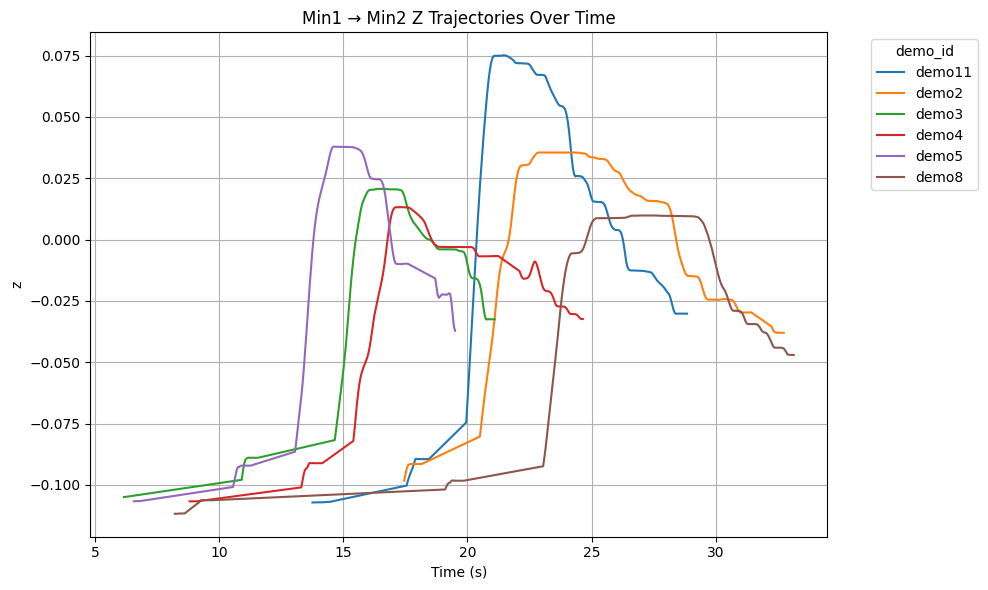

In [17]:
# --- Plot ALL included demos on the SAME Z vs Time figure ---
plt.figure(figsize=(10, 6))

for demo_id, traj_df in xy_segments.items():
    # safety: skip empties
    if traj_df is None or len(traj_df) == 0:
        continue

    # ensure ordered by time
    if 't' in traj_df.columns:
        traj_df = traj_df.sort_values('t')

    plt.plot(
        traj_df['t'].to_numpy(),
        traj_df['z'].to_numpy(),
        label=demo_id
    )

plt.title("Min1 → Min2 Z Trajectories Over Time")
plt.xlabel("Time (s)")
plt.ylabel("z")
plt.grid(True)
plt.legend(title="demo_id", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("figs/z-trajs.pdf")
plt.show()


### DTW Distance

In [18]:
# pip install dtw-python

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Trajectories: ['demo11', 'demo2', 'demo3', 'demo4', 'demo5', 'demo8'] count: 6


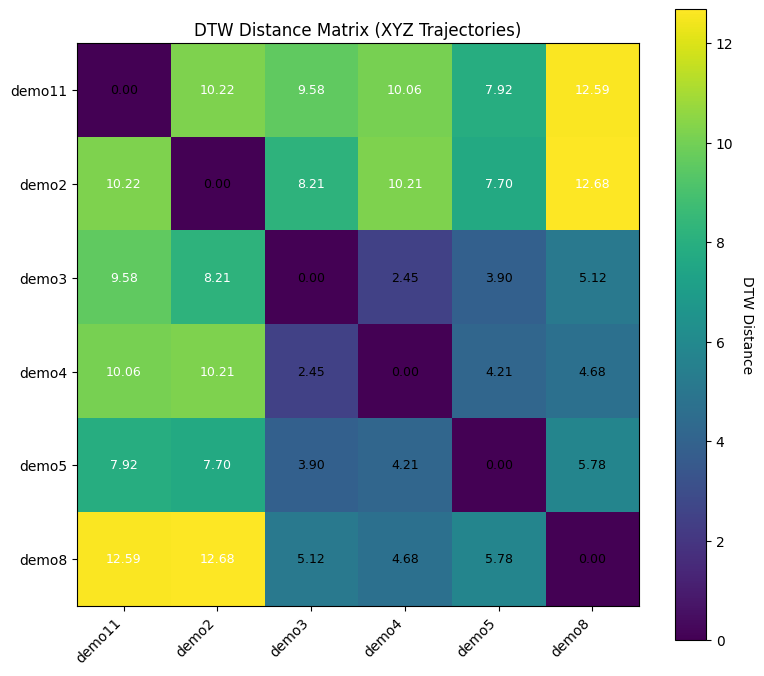

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dtw import dtw

def traj_to_xyz_array(traj_df, x_col="x", y_col="y", z_col="z", t_col="timestep"):
    """Return Nx3 float array (x,y,z), sorted by timestep if present, dropping NaNs."""
    df = traj_df.copy()
    if t_col in df.columns:
        df = df.sort_values(t_col)

    arr = df[[x_col, y_col, z_col]].to_numpy(dtype=float)
    arr = arr[np.isfinite(arr).all(axis=1)]  # drop rows with NaNs/inf across x,y,z
    return arr

# ---- 1) Collect trajectories as Nx3 arrays ----
traj_arrays = {}
for demo_id, traj_df in xy_segments.items():  # keep your dict name; it can still hold z
    if traj_df is None or len(traj_df) == 0:
        continue

    A = traj_to_xyz_array(traj_df)  # now Nx3
    if len(A) == 0:
        continue

    traj_arrays[str(demo_id)] = A

demo_ids = sorted(traj_arrays.keys())
n = len(demo_ids)
print("Trajectories:", demo_ids, "count:", n)

# ---- 2) Pairwise DTW distance matrix ----
D = np.zeros((n, n), dtype=float)

for i, id_i in enumerate(demo_ids):
    for j, id_j in enumerate(demo_ids):
        if j < i:
            D[i, j] = D[j, i]
            continue

        xi = traj_arrays[id_i]  # shape (Ti, 3)
        xj = traj_arrays[id_j]  # shape (Tj, 3)

        # dtw-python can compute Euclidean distance between 3D rows the same way
        alignment = dtw(xi, xj, dist_method="euclidean")
        D[i, j] = alignment.distance
        D[j, i] = D[i, j]

dist_df = pd.DataFrame(D, index=demo_ids, columns=demo_ids)

M = dist_df.values
labels = dist_df.index.tolist()

plt.figure(figsize=(8, 7))
im = plt.imshow(M)

# Colorbar
cbar = plt.colorbar(im)
cbar.set_label("DTW Distance", rotation=270, labelpad=15)

# Axis ticks & labels
plt.xticks(np.arange(len(labels)), labels, rotation=45, ha="right")
plt.yticks(np.arange(len(labels)), labels)

# Annotate each cell with numeric value
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(
            j, i,
            f"{M[i, j]:.2f}",
            ha="center",
            va="center",
            color="white" if M[i, j] > M.max() * 0.5 else "black",
            fontsize=9
        )

plt.title("DTW Distance Matrix (XYZ Trajectories)")
plt.tight_layout()
plt.savefig("figs/DistanceMatrix.pdf")
plt.show()



From this we can see that Demo4 would be an optimal reference timeline and demos 11 and 2 are outliers.

### Applying DTW to Demos 4 and 5

DTW distance: 2.452474518160353


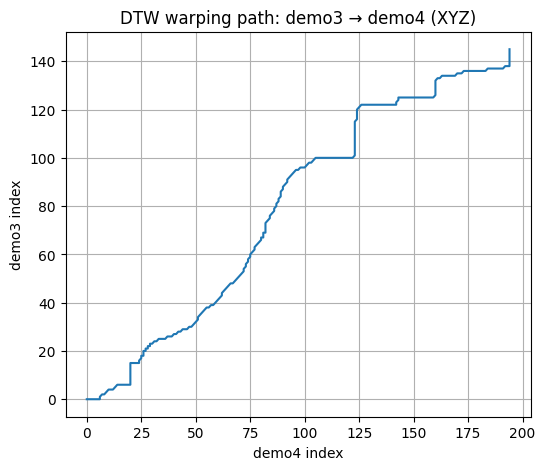

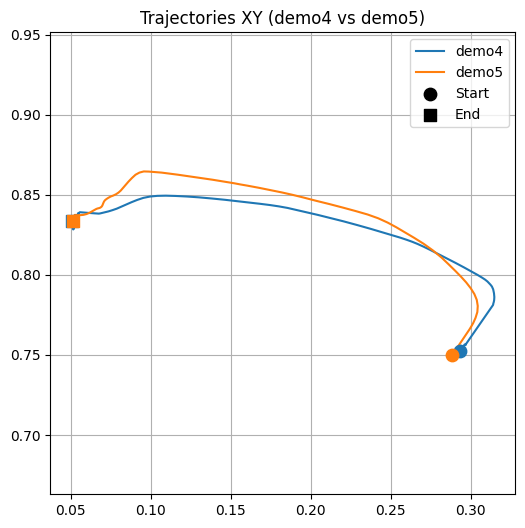

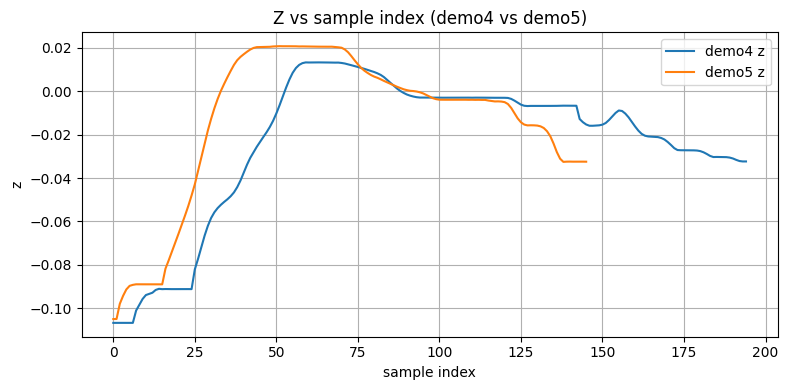

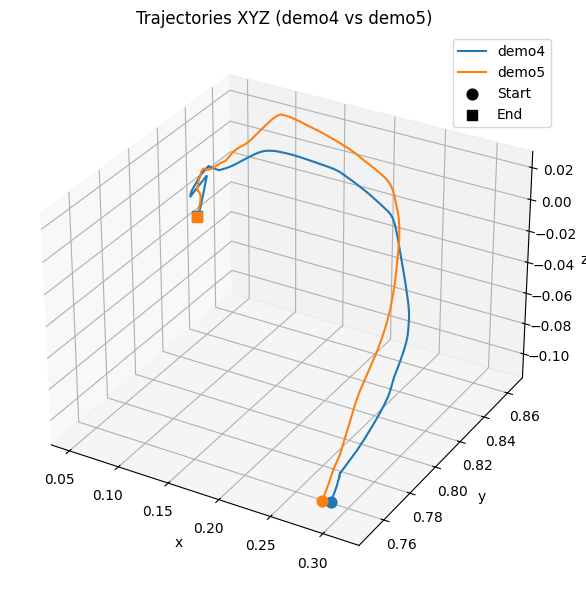

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw

def get_xyz_sequence(xy_segments, demo_id, cols=("x", "y", "z")):
    traj_df = xy_segments.get(demo_id)
    if traj_df is None or len(traj_df) == 0:
        raise ValueError(f"{demo_id} missing or empty in xy_segments.")

    # order by time if present
    if "timestep" in traj_df.columns:
        traj_df = traj_df.sort_values("timestep")

    # keep only the needed columns, drop NaN/inf rows across x,y,z
    arr = traj_df.loc[:, list(cols)].to_numpy(dtype=float)
    arr = arr[np.isfinite(arr).all(axis=1)]
    if len(arr) == 0:
        raise ValueError(f"{demo_id} has no finite rows in columns {cols}.")

    # (T, 3) sequence: [x, y, z]
    return arr

# ---- Select only demo4 and demo5 ----
seq4 = get_xyz_sequence(xy_segments, "demo4")  # shape (T4, 3)
seq5 = get_xyz_sequence(xy_segments, "demo3")  # shape (T5, 3)

# ---- DTW on 3D points (x,y,z) ----
alignment = dtw(seq4, seq5, dist_method="euclidean", keep_internals=True)

print("DTW distance:", float(alignment.distance))

# ---- Plot the warping path (index mapping) ----
plt.figure(figsize=(6, 5))
plt.plot(alignment.index1, alignment.index2)
plt.title("DTW warping path: demo3 → demo4 (XYZ)")
plt.xlabel("demo4 index")
plt.ylabel("demo3 index")
plt.grid(True)
plt.savefig("figs/WarpingPath.pdf")
plt.show()

# ---- Optional: plot trajectories in XY (same as before) ----
plt.figure(figsize=(6, 6))

# demo4
line4, = plt.plot(seq4[:, 0], seq4[:, 1], label="demo4")
c4 = line4.get_color()
plt.scatter(seq4[0, 0],  seq4[0, 1],  marker="o", s=80, color=c4, zorder=5)  # start
plt.scatter(seq4[-1, 0], seq4[-1, 1], marker="s", s=80, color=c4, zorder=5)  # end

# demo5
line5, = plt.plot(seq5[:, 0], seq5[:, 1], label="demo5")
c5 = line5.get_color()
plt.scatter(seq5[0, 0],  seq5[0, 1],  marker="o", s=80, color=c5, zorder=5)  # start
plt.scatter(seq5[-1, 0], seq5[-1, 1], marker="s", s=80, color=c5, zorder=5)  # end

plt.axis("equal")
plt.grid(True)
plt.scatter([], [], marker="o", s=80, color="black", label="Start")
plt.scatter([], [], marker="s", s=80, color="black", label="End")

plt.legend()
plt.title("Trajectories XY (demo4 vs demo5)")
plt.show()


# ---- Optional: plot Z over sample index (helps verify z alignment) ----
plt.figure(figsize=(8, 4))
plt.plot(seq4[:, 2], label="demo4 z")
plt.plot(seq5[:, 2], label="demo5 z")
plt.grid(True)
plt.legend()
plt.title("Z vs sample index (demo4 vs demo5)")
plt.xlabel("sample index")
plt.ylabel("z")
plt.tight_layout()
plt.show()

# ---- Optional: show 3D curves (if you want a true XYZ view) ----
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")

# demo4
line4, = ax.plot(seq4[:, 0], seq4[:, 1], seq4[:, 2], label="demo4")
c4 = line4.get_color()
ax.scatter(seq4[0, 0],  seq4[0, 1],  seq4[0, 2],  marker="o", s=60, color=c4)
ax.scatter(seq4[-1, 0], seq4[-1, 1], seq4[-1, 2], marker="s", s=60, color=c4)

# demo5
line5, = ax.plot(seq5[:, 0], seq5[:, 1], seq5[:, 2], label="demo5")
c5 = line5.get_color()
ax.scatter(seq5[0, 0],  seq5[0, 1],  seq5[0, 2],  marker="o", s=60, color=c5)
ax.scatter(seq5[-1, 0], seq5[-1, 1], seq5[-1, 2], marker="s", s=60, color=c5)

ax.set_title("Trajectories XYZ (demo4 vs demo5)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.scatter([], [], [], marker="o", s=60, color="black", label="Start")
ax.scatter([], [], [], marker="s", s=60, color="black", label="End")

ax.legend()
plt.tight_layout()
plt.show()


### Multiscale DTW on Demos 4 and 5

We first perform the DTW at low resolution and then upsample and perform it across a limitted range reducing compute at many unnecessary high resolution points.

DTW complexity frops from $O(N^2)$ to $O(Nr)$

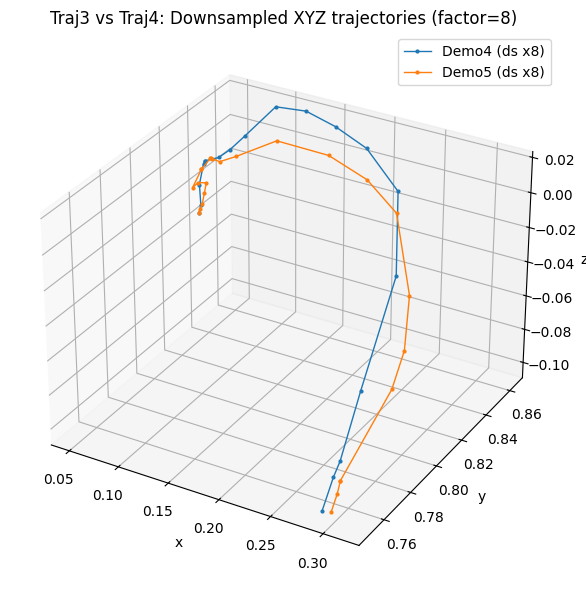

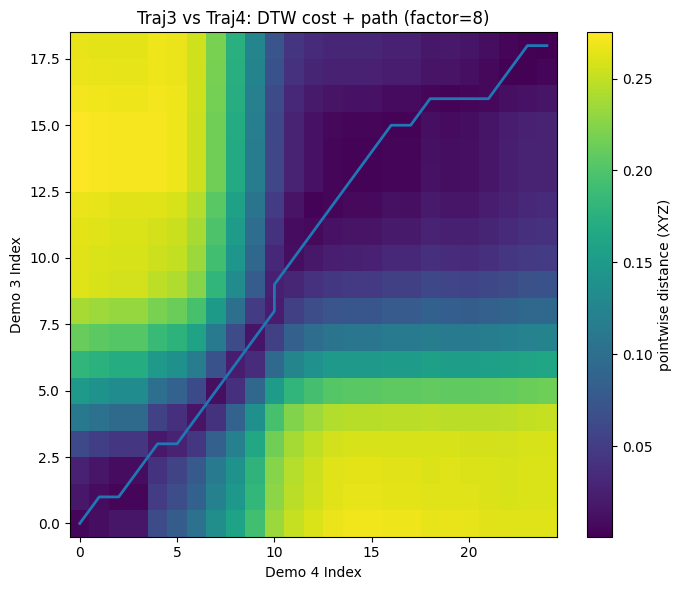

[factor=8] DTW distance: 0.2526 | path length: 26


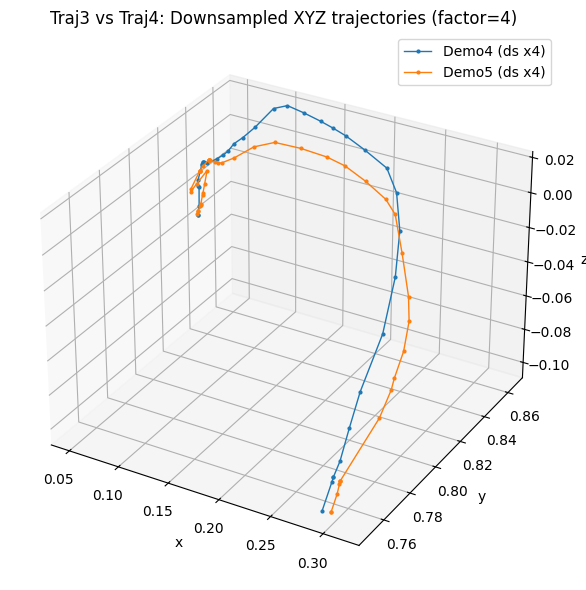

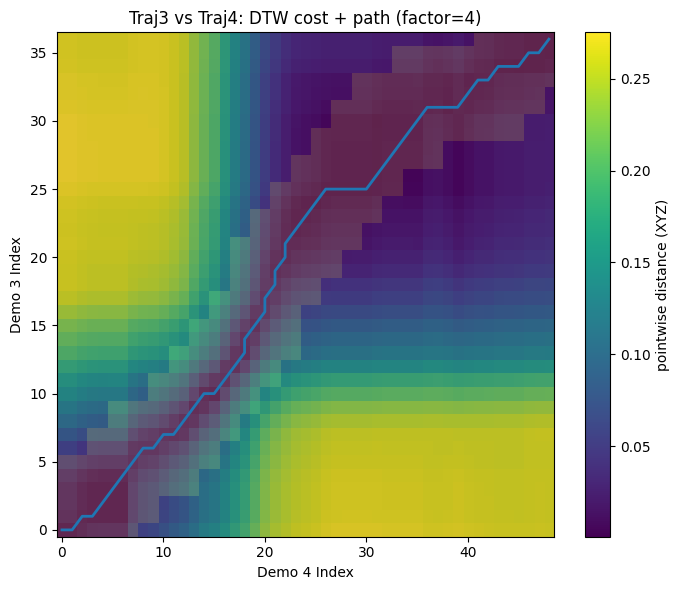

[factor=4] DTW distance: 0.4474 | path length: 53


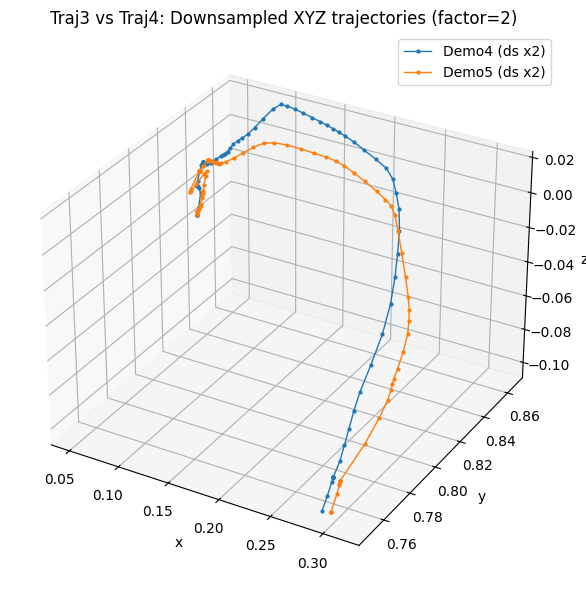

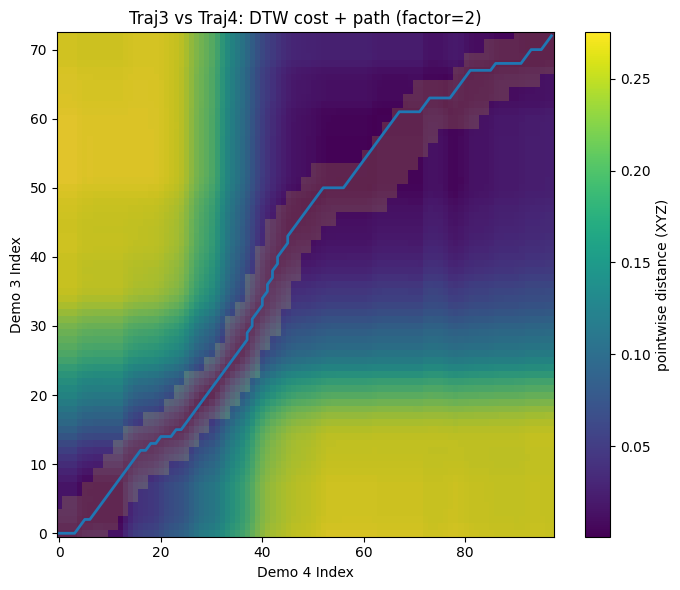

[factor=2] DTW distance: 0.7987 | path length: 105


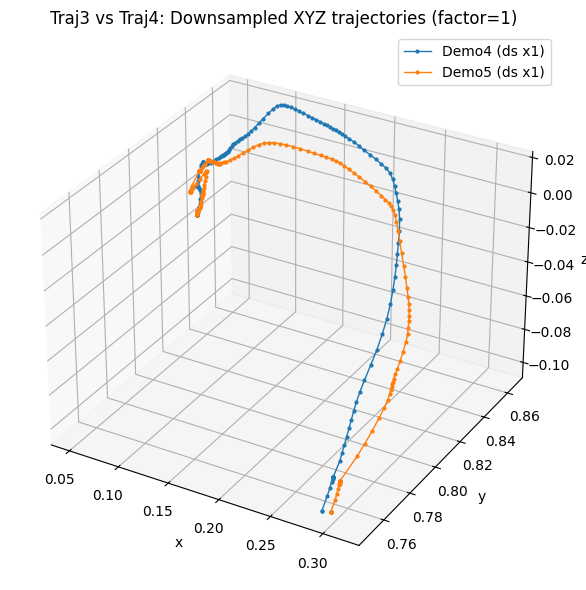

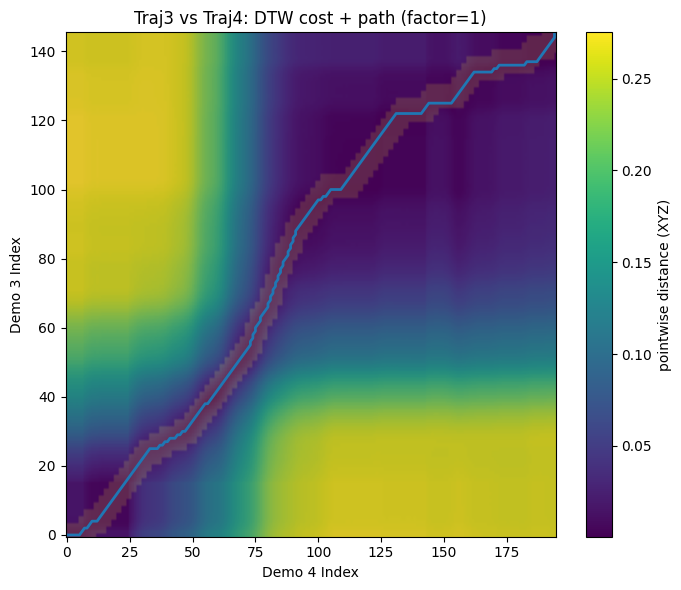

[factor=1] DTW distance: 1.5583 | path length: 211

Final full-res DTW distance: 1.5583423857613354


In [21]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Helpers (now for XYZ)
# -----------------------------
def to_xyz(traj_df):
    """
    Convert traj_df to (T,3) float array using columns x,y,z.
    """
    return traj_df[['x', 'y', 'z']].to_numpy(dtype=float)

def downsample_seq(seq, factor):
    """
    Generic downsample for (T,D) sequence.
    """
    if factor <= 1:
        return seq
    return seq[::factor]

def pointwise_dist_matrix(A, B):
    """
    A: (N,D), B: (M,D) -> cost: (N,M) where cost[i,j]=||A[i]-B[j]||_2
    Works for D=2,3,... automatically.
    """
    return np.linalg.norm(A[:, None, :] - B[None, :, :], axis=-1)

def dtw_constrained(cost, band_mask=None):
    N, M = cost.shape
    INF = 1e18
    D = np.full((N, M), INF, dtype=float)
    P = np.full((N, M, 2), -1, dtype=int)

    def allowed(i, j):
        return True if band_mask is None else band_mask[i, j]

    if not allowed(0, 0):
        raise ValueError("Band mask excludes (0,0). Widen band / fix mask.")

    D[0, 0] = cost[0, 0]

    for i in range(1, N):
        if allowed(i, 0) and D[i-1, 0] < INF:
            D[i, 0] = cost[i, 0] + D[i-1, 0]
            P[i, 0] = (i-1, 0)
    for j in range(1, M):
        if allowed(0, j) and D[0, j-1] < INF:
            D[0, j] = cost[0, j] + D[0, j-1]
            P[0, j] = (0, j-1)

    for i in range(1, N):
        for j in range(1, M):
            if not allowed(i, j):
                continue
            choices = [
                (D[i-1, j],   (i-1, j)),
                (D[i, j-1],   (i, j-1)),
                (D[i-1, j-1], (i-1, j-1)),
            ]
            best_val, (pi, pj) = min(choices, key=lambda t: t[0])
            if best_val >= INF:
                continue
            D[i, j] = cost[i, j] + best_val
            P[i, j] = (pi, pj)

    if (band_mask is not None and not band_mask[N-1, M-1]) or D[N-1, M-1] >= INF:
        raise ValueError("No valid DTW path under current band. Increase band_radius.")

    path = []
    i, j = N-1, M-1
    path.append((i, j))
    while not (i == 0 and j == 0):
        pi, pj = P[i, j]
        if pi < 0:
            raise RuntimeError("Backpointer missing; band too tight.")
        i, j = int(pi), int(pj)
        path.append((i, j))
    path.reverse()
    return D[N-1, M-1], path

def band_from_path(path_coarse, N_fine, M_fine, scale_i, scale_j, band_radius):
    mask = np.zeros((N_fine, M_fine), dtype=bool)
    for (ic, jc) in path_coarse:
        i0 = int(round(ic * scale_i))
        j0 = int(round(jc * scale_j))
        i_min = max(0, i0 - band_radius)
        i_max = min(N_fine - 1, i0 + band_radius)
        j_min = max(0, j0 - band_radius)
        j_max = min(M_fine - 1, j0 + band_radius)
        mask[i_min:i_max+1, j_min:j_max+1] = True
    mask[0, 0] = True
    mask[N_fine-1, M_fine-1] = True
    return mask

# -----------------------------
# Plotting helpers (3D traj + cost/path)
# -----------------------------
def plot_xyz_downsampled(A, B, factor, title_prefix=""):
    """
    A, B are (T,3) sequences. Plot 3D trajectories.
    """
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(A[:, 0], A[:, 1], A[:, 2], marker='o', markersize=2, linewidth=1, label=f"Demo4 (ds x{factor})")
    ax.plot(B[:, 0], B[:, 1], B[:, 2], marker='o', markersize=2, linewidth=1, label=f"Demo5 (ds x{factor})")

    ax.set_title(f"{title_prefix}Downsampled XYZ trajectories (factor={factor})")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"figs/DownsampledTrajs(factor={factor}).pdf")
    plt.show()

def plot_cost_and_path(cost, path, factor, band_mask=None, title_prefix=""):
    plt.figure(figsize=(7, 6))

    plt.imshow(cost, origin='lower', aspect='auto')
    plt.colorbar(label="pointwise distance (XYZ)")

    if band_mask is not None:
        overlay = np.zeros_like(cost, dtype=float)
        overlay[band_mask] = 1.0
        plt.grid(False)
        plt.imshow(overlay, origin='lower', aspect='auto', alpha=0.15, zorder=2, rasterized=True )

    pi = [p[0] for p in path]
    pj = [p[1] for p in path]
    plt.plot(pj, pi, linewidth=2)  # x-axis is j, y-axis is i

    plt.title(f"{title_prefix}DTW cost + path (factor={factor})")
    plt.xlabel("Demo 4 Index")
    plt.ylabel("Demo 3 Index")
    plt.tight_layout()
    plt.grid(False)
    plt.savefig(f"figs/DTWCost+Path(factor={factor}).pdf")
    plt.show()

# -----------------------------
# Multiscale DTW for XYZ
# -----------------------------
def multiscale_dtw_with_plots(seqA_full, seqB_full, factors=(8, 4, 2, 1), band_radius=20,
                              plot_each_level=True, title_prefix=""):
    records = []
    prev_path = None
    prev_N = prev_M = None

    for factor in factors:
        A = downsample_seq(seqA_full, factor)
        B = downsample_seq(seqB_full, factor)
        N, M = len(A), len(B)
        cost = pointwise_dist_matrix(A, B)

        band = None
        if prev_path is None:
            total, path = dtw_constrained(cost, band_mask=None)
        else:
            scale_i = (N - 1) / max(1, (prev_N - 1))
            scale_j = (M - 1) / max(1, (prev_M - 1))
            band = band_from_path(prev_path, N, M, scale_i, scale_j, band_radius)
            total, path = dtw_constrained(cost, band_mask=band)

        records.append({
            "factor": factor,
            "A": A, "B": B,
            "cost": cost,
            "path": path,
            "total": total,
            "band": band
        })

        if plot_each_level:
            plot_xyz_downsampled(A, B, factor, title_prefix=title_prefix)
            plot_cost_and_path(cost, path, factor, band_mask=band, title_prefix=title_prefix)
            print(f"[factor={factor}] DTW distance: {total:.4f} | path length: {len(path)}")

        prev_path = path
        prev_N, prev_M = N, M

    return records

# -----------------------------
# Run on trajectories 4 and 5 (XYZ)
# -----------------------------
traj4 = xy_segments[4] if 4 in xy_segments else xy_segments["demo4"]
traj3 = xy_segments[5] if 5 in xy_segments else xy_segments["demo3"]

# Now we need x,y,z in the dataframe
seq4 = to_xyz(traj4)
seq3 = to_xyz(traj3)

records = multiscale_dtw_with_plots(
    seq3, seq4,
    factors=(8, 4, 2, 1),
    band_radius=3,
    plot_each_level=True,
    title_prefix="Traj3 vs Traj4: "
)

final = records[-1]
print("\nFinal full-res DTW distance:", final["total"])


In [22]:
# Full-resolution XYZ sequences
xyz4 = to_xyz(traj4)
xyz3 = to_xyz(traj3)

# Cost matrix (uses x,y,z automatically)
cost_full = pointwise_dist_matrix(xyz4, xyz3)

# Unconstrained DTW
dist_full, path_full = dtw_constrained(cost_full, band_mask=None)

print("Full-resolution XYZ DTW distance:", dist_full)


Full-resolution XYZ DTW distance: 1.5571784833726063


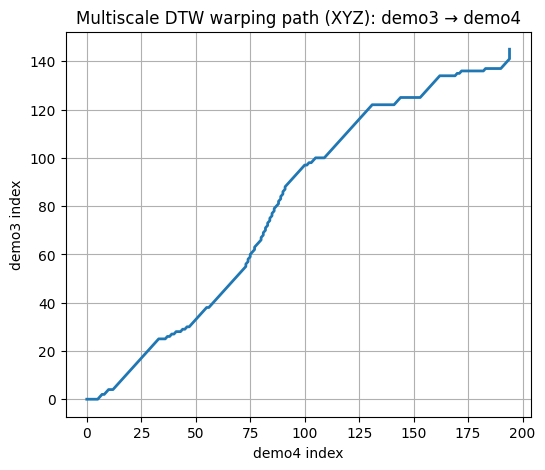

In [23]:
# Extract indices from path
i_idx = [p[0] for p in path_full]  # demo5 indices (row / i)
j_idx = [p[1] for p in path_full]  # demo4 indices (col / j)

plt.figure(figsize=(6, 5))
plt.plot(i_idx, j_idx, linewidth=2)
plt.title("Multiscale DTW warping path (XYZ): demo3 → demo4")
plt.xlabel("demo4 index")
plt.ylabel("demo3 index")
plt.grid(True)
plt.savefig("figs/MultiscaleWarpingPath.pdf")
plt.show()


### Multiscale DTW on multiple Demos

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def warp_seq_to_reference(seq_demo, seq_ref, path_demo_ref, reducer="mean"):
    """
    Warp seq_demo (N,3) onto seq_ref timeline (M,3) using DTW path.

    path_demo_ref is a list of (i, j) tuples where:
      i indexes seq_demo
      j indexes seq_ref

    Returns:
      aligned_demo: (M,3) demo points resampled onto reference indices
    """
    M = len(seq_ref)

    # map each reference index j -> list of demo indices i aligned to it
    bucket = [[] for _ in range(M)]
    for (i, j) in path_demo_ref:
        if 0 <= j < M and 0 <= i < len(seq_demo):
            bucket[j].append(i)

    aligned = np.zeros((M, seq_demo.shape[1]), dtype=float)

    last_valid = None
    for j in range(M):
        idxs = bucket[j]
        if len(idxs) > 0:
            pts = seq_demo[idxs]
            if reducer == "mean":
                aligned[j] = pts.mean(axis=0)
            elif reducer == "median":
                aligned[j] = np.median(pts, axis=0)
            else:
                raise ValueError("reducer must be 'mean' or 'median'")
            last_valid = aligned[j].copy()
        else:
            # if DTW path skipped this ref index, fill by carrying forward
            if last_valid is not None:
                aligned[j] = last_valid
            else:
                # if we're at the beginning and have nothing yet, use first demo point
                aligned[j] = seq_demo[0]

    return aligned


In [25]:
# -----------------------------
# Helper: fetch demo -> xyz array (handles "demo4" vs 4 keys)
# -----------------------------
def get_demo_xyz(xy_segments, demo_id):
    # allow demo_id as int (4) or str ("demo4")
    candidates = []
    if isinstance(demo_id, int):
        candidates = [demo_id, f"demo{demo_id}"]
    else:
        candidates = [demo_id]
        # if user passed "demo4", also try 4
        if isinstance(demo_id, str) and demo_id.startswith("demo") and demo_id[4:].isdigit():
            candidates.append(int(demo_id[4:]))

    traj_df = None
    for k in candidates:
        if k in xy_segments:
            traj_df = xy_segments[k]
            break

    if traj_df is None or len(traj_df) == 0:
        raise KeyError(f"Could not find non-empty trajectory for {demo_id}. Tried keys: {candidates}")

    # stable time ordering if present
    if "timestep" in traj_df.columns:
        traj_df = traj_df.sort_values("timestep")
    elif "t" in traj_df.columns:
        traj_df = traj_df.sort_values("t")

    # IMPORTANT: now returning x,y,z
    required = ["x", "y", "z"]
    missing = [c for c in required if c not in traj_df.columns]
    if missing:
        raise KeyError(f"Trajectory {demo_id} is missing columns: {missing}. Found: {list(traj_df.columns)}")

    return traj_df[["x", "y", "z"]].to_numpy(dtype=float)

In [26]:
def align_demos_to_reference_xyz(
    xy_segments,
    demo_ids=("demo3", "demo4", "demo5", "demo8"),
    reference_demo="demo4",
    factors=(8, 4, 2, 1),
    band_radius=3,
    reducer="mean",
    do_plots=False
):
    """
    Align each demo in demo_ids to reference_demo timeline using multiscale DTW (XYZ).

    Returns:
      ref_id: reference_demo
      ref_seq: (M,3)
      aligned: dict demo_id -> (M,3) aligned sequence (same length as ref)
      paths: dict demo_id -> dtw path (i demo, j ref) for full resolution
      records: dict demo_id -> multiscale dtw records (optional useful debugging)
    """
    demo_ids = list(demo_ids)
    if reference_demo not in demo_ids:
        demo_ids = [reference_demo] + demo_ids

    # load all sequences (XYZ)
    seqs = {d: get_demo_xyz(xy_segments, d) for d in demo_ids}

    ref_seq = seqs[reference_demo]
    aligned = {reference_demo: ref_seq.copy()}
    paths = {reference_demo: None}
    records_by_demo = {reference_demo: None}

    for d in demo_ids:
        if d == reference_demo:
            continue

        # DTW expects (seq_demo, seq_ref) so path tuples are (i_demo, j_ref)
        records = multiscale_dtw_with_plots(
            seqs[d], ref_seq,
            factors=factors,
            band_radius=band_radius,
            plot_each_level=do_plots,
            title_prefix=f"{d} → {reference_demo}: "
        )

        path_full = records[-1]["path"]     # list of (i_demo, j_ref)
        aligned[d] = warp_seq_to_reference(seqs[d], ref_seq, path_full, reducer=reducer)

        paths[d] = path_full
        records_by_demo[d] = records

        print(f"[ALIGNED] {d} → {reference_demo} | full-res DTW distance = {records[-1]['total']:.6f}")

    return reference_demo, ref_seq, aligned, paths, records_by_demo


In [27]:
def plot_aligned_3d_with_timeline_markers(
    aligned_dict,
    marker_step=10,   # every N points along the timeline
    title="All demos aligned to demo4 timeline (XYZ)"
):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    for demo_id, seq in aligned_dict.items():
        # plot line and capture color
        line, = ax.plot(
            seq[:, 0],
            seq[:, 1],
            seq[:, 2],
            linewidth=2,
            label=str(demo_id)
        )
        c = line.get_color()

        # ---- timeline markers (show local time warping) ----
        idx = np.arange(0, len(seq), marker_step)
        ax.scatter(
            seq[idx, 0],
            seq[idx, 1],
            seq[idx, 2],
            s=12,
            color=c,
            alpha=0.9
        )

        # ---- start (circle) ----
        ax.scatter(
            seq[0, 0], seq[0, 1], seq[0, 2],
            marker='o',
            s=50,
            color=c,
            zorder=5
        )

        # ---- end (square) ----
        ax.scatter(
            seq[-1, 0], seq[-1, 1], seq[-1, 2],
            marker='s',
            s=60,
            color=c,
            zorder=5
        )

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.savefig("figs/MultiscaleDemos.pdf")
    plt.show()


[ALIGNED] demo3 → demo4 | full-res DTW distance = 1.558342
[ALIGNED] demo5 → demo4 | full-res DTW distance = 2.734251
[ALIGNED] demo8 → demo4 | full-res DTW distance = 3.093710


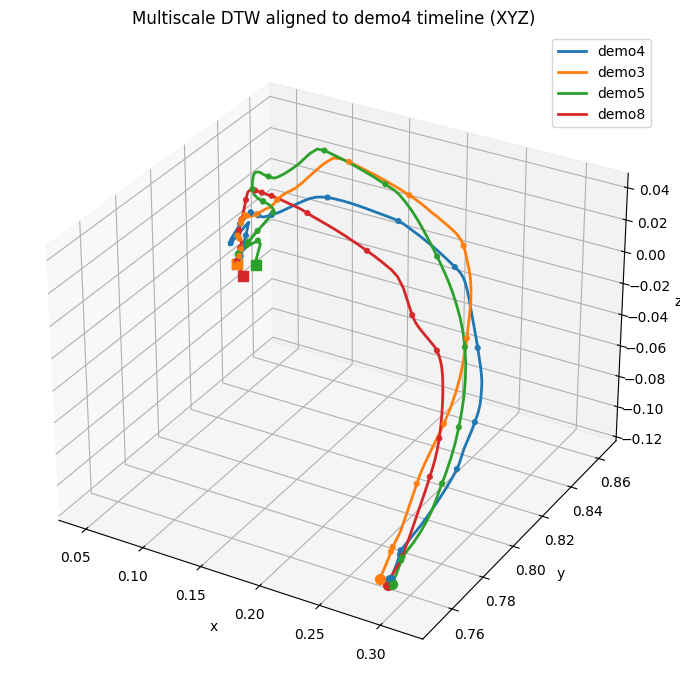

In [28]:
demo_ids = ("demo3", "demo4", "demo5", "demo8")

ref_id, ref_seq, aligned, paths, records = align_demos_to_reference_xyz(
    xy_segments,
    demo_ids=demo_ids,
    reference_demo="demo4",
    factors=(8, 4, 2, 1),
    band_radius=3,
    reducer="mean",
    do_plots=False   # set True if you want per-level DTW plots for debugging
)

plot_aligned_3d_with_timeline_markers(
    aligned,
    marker_step=10,   # try 5–15 depending on density
    title=f"Multiscale DTW aligned to {ref_id} timeline (XYZ)"
)


## Part D. Gaussian Mixture Model and Regression

https://scikit-learn.org/stable/modules/mixture.html

### Preprocess Data

In [29]:
import numpy as np
import pandas as pd

def _get_final_path(pair_records, a, b):
    """
    Returns (path, order) where:
      - path is list[(i, j)]
      - order is "a_to_b" meaning i indexes a and j indexes b in that stored pair.
    """
    if (a, b) in pair_records:
        records = pair_records[(a, b)]
        path = records[-1]["path"]
        return path, "a_to_b"
    elif (b, a) in pair_records:
        records = pair_records[(b, a)]
        path = records[-1]["path"]
        # path is (i_b, j_a) in this stored order (b->a)
        return path, "b_to_a"
    else:
        raise KeyError(f"No DTW records found for pair ({a}, {b}) in either order.")


def warp_demo_to_reference_nd(demo_seq, ref_len, path):
    """
    Generic warping for D-dimensional sequences (e.g., D=3 for XYZ).
    Builds aligned_seq with length ref_len.

    Expects path tuples in (i_demo, j_ref) format.
    Uses mean to resolve many-to-one matches.
    """
    D = demo_seq.shape[1]
    aligned = np.full((ref_len, D), np.nan, dtype=float)

    # bucket[j_ref] = [i_demo indices...]
    buckets = [[] for _ in range(ref_len)]

    for (i_demo, j_ref) in path:
        i_demo = int(i_demo)
        j_ref = int(j_ref)
        if 0 <= j_ref < ref_len and 0 <= i_demo < len(demo_seq):
            buckets[j_ref].append(i_demo)

    # fill with mean of matched demo points
    for r in range(ref_len):
        if len(buckets[r]) == 0:
            continue
        pts = demo_seq[buckets[r], :]
        aligned[r, :] = pts.mean(axis=0)

    # forward fill missing
    for r in range(1, ref_len):
        if np.any(np.isnan(aligned[r])) and not np.any(np.isnan(aligned[r-1])):
            aligned[r] = aligned[r-1]

    # backward fill missing
    for r in range(ref_len - 2, -1, -1):
        if np.any(np.isnan(aligned[r])) and not np.any(np.isnan(aligned[r+1])):
            aligned[r] = aligned[r+1]

    # still NaNs means your band/path missed parts of the reference
    if np.any(np.isnan(aligned)):
        bad = np.where(np.isnan(aligned).any(axis=1))[0][:10]
        raise RuntimeError(f"Alignment contains NaNs at ref indices like {bad}. Band may be too tight.")

    return aligned


def build_gmm_df_from_dtw_xyz(
    demos_xyz,
    pair_records,
    reference_demo="demo4",
    demo_ids=("demo3", "demo4", "demo5", "demo8"),
):
    """
    Returns a DataFrame ready for GMM on (t_norm, x, y, z) with all demos aligned
    to reference_demo timeline using DTW paths in pair_records.

    Inputs:
      demos_xyz: dict demo_id -> (T_i, 3) array
      pair_records: dict (a,b) -> multiscale records; records[-1]["path"] is final path

    Output columns:
      demo_id, t_ref, t_norm, x, y, z, reference_demo
    """
    demo_ids = list(demo_ids)

    if reference_demo not in demos_xyz:
        raise KeyError(f"reference_demo={reference_demo} not in demos_xyz keys: {list(demos_xyz.keys())}")

    ref_xyz = demos_xyz[reference_demo]
    T_ref = len(ref_xyz)

    if ref_xyz.shape[1] != 3:
        raise ValueError(f"Expected reference demo to have shape (T,3). Got {ref_xyz.shape}")

    rows = []

    # reference timeline
    t_ref = np.arange(T_ref, dtype=int)
    t_norm = t_ref / (T_ref - 1) if T_ref > 1 else t_ref.astype(float)

    for d in demo_ids:
        if d not in demos_xyz:
            raise KeyError(f"{d} not in demos_xyz keys: {list(demos_xyz.keys())}")

        demo_seq = demos_xyz[d]
        if demo_seq.shape[1] != 3:
            raise ValueError(f"Expected {d} to have shape (T,3). Got {demo_seq.shape}")

        if d == reference_demo:
            aligned_xyz = ref_xyz.copy()
        else:
            # get final DTW path (might be stored either direction)
            path, order = _get_final_path(pair_records, d, reference_demo)

            if order == "a_to_b":
                # stored as (d, ref): path tuples are (i_d, j_ref) => already what we need
                path_demo_ref = [(int(i), int(j)) for (i, j) in path]
            else:
                # stored as (ref, d): path tuples are (i_ref, j_d)
                # convert to (i_demo, j_ref) by swapping (j_d, i_ref)
                path_demo_ref = [(int(j), int(i)) for (i, j) in path]

            aligned_xyz = warp_demo_to_reference_nd(demo_seq, T_ref, path_demo_ref)

        df_d = pd.DataFrame({
            "demo_id": d,
            "t_ref": t_ref,
            "t_norm": t_norm,
            "x": aligned_xyz[:, 0],
            "y": aligned_xyz[:, 1],
            "z": aligned_xyz[:, 2],
            "reference_demo": reference_demo
        })
        rows.append(df_d)

    gmm_df_xyz = pd.concat(rows, ignore_index=True)
    return gmm_df_xyz

In [30]:
reference_demo = "demo4"
demo_ids = ("demo3", "demo4", "demo5", "demo8")

# demo IDs you care about
demo_ids = ("demo3", "demo4", "demo5", "demo8")

# Raw XYZ trajectories (unaligned)
demos_xyz = {
    d: get_demo_xyz(xy_segments, d)
    for d in demo_ids
}

pair_records = {}

for d in demo_ids:
    if d == reference_demo:
        continue

    records = multiscale_dtw_with_plots(
        demos_xyz[d],                 # demo sequence (XYZ)
        demos_xyz[reference_demo],    # reference sequence (XYZ)
        factors=(8, 4, 2, 1),
        band_radius=3,
        plot_each_level=False,
        title_prefix=f"{d} → {reference_demo}: "
    )

    # Store using (demo, reference) ordering
    pair_records[(d, reference_demo)] = records

    print(
        f"[DTW STORED] {d} → {reference_demo} | "
        f"final DTW distance = {records[-1]['total']:.6f}"
    )

[DTW STORED] demo3 → demo4 | final DTW distance = 1.558342
[DTW STORED] demo5 → demo4 | final DTW distance = 2.734251
[DTW STORED] demo8 → demo4 | final DTW distance = 3.093710


In [31]:

gmm_df = build_gmm_df_from_dtw_xyz(
    demos_xyz=demos_xyz,
    pair_records=pair_records,
    reference_demo="demo4",
    demo_ids=("demo3", "demo4", "demo5", "demo8")
)

print(gmm_df.head())
print(gmm_df.shape)

  demo_id  t_ref    t_norm         x         y        z reference_demo
0   demo3      0  0.000000  0.288233  0.749889 -0.10492          demo4
1   demo3      1  0.005155  0.288233  0.749889 -0.10492          demo4
2   demo3      2  0.010309  0.288233  0.749889 -0.10492          demo4
3   demo3      3  0.015464  0.288233  0.749889 -0.10492          demo4
4   demo3      4  0.020619  0.288233  0.749889 -0.10492          demo4
(780, 7)


### BIC

C:\Users\Jaxba\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Jaxba\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Jaxba\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Jaxba\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Wi

Selected n_components = 11
BIC = -3223.8476622931685


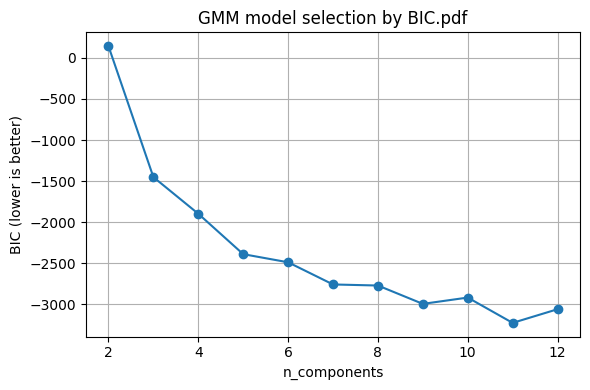

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Prepare training matrix
# -----------------------------
feat_cols = ["t_norm", "x", "y", "z"]
X = gmm_df[feat_cols].to_numpy(dtype=float)

# (strongly recommended) scale features so GMM doesn't get dominated by x/y magnitude
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# -----------------------------
# Pick number of components using BIC
# -----------------------------
k_candidates = range(2, 13)  # adjust range if you want
bics = []
models = []

for k in k_candidates:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        reg_covar=1e-6,
        random_state=0
    )
    gmm.fit(Xz)
    bics.append(gmm.bic(Xz))
    models.append(gmm)

best_idx = int(np.argmin(bics))
best_k = list(k_candidates)[best_idx]
gmm = models[best_idx]

print("Selected n_components =", best_k)
print("BIC =", bics[best_idx])

# Plot BIC curve
plt.figure(figsize=(6,4))
plt.plot(list(k_candidates), bics, marker="o")
plt.xlabel("n_components")
plt.ylabel("BIC (lower is better)")
plt.title("GMM model selection by BIC.pdf")
plt.grid(True)
plt.tight_layout()
plt.savefig("figs/BIC.pdf")
plt.show()


### GMM

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def _unscale_mean_and_cov_2d(mean_z, cov_z, scaler, idxs):
    """
    mean_z: (D,) in z-space, where D=4 for [t_norm, x, y, z]
    cov_z : (D,D) in z-space
    idxs  : two indices (e.g., [0,1] for t_norm vs x)

    Returns:
      mean_raw_2d (2,)
      cov_raw_2d  (2,2)
    """
    idxs = list(idxs)
    m2_z = mean_z[idxs]
    S2_z = cov_z[np.ix_(idxs, idxs)]

    # raw = z * scale + mean  (StandardScaler convention)
    scale2 = scaler.scale_[idxs]
    mean2  = scaler.mean_[idxs]

    m2_raw = m2_z * scale2 + mean2
    A = np.diag(scale2)
    S2_raw = A @ S2_z @ A
    return m2_raw, S2_raw

def _ellipse_from_cov(mean2, cov2, n_std=2.0, **patch_kwargs):
    """
    mean2: (2,)
    cov2 : (2,2)
    """
    vals, vecs = np.linalg.eigh(cov2)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    width, height = 2 * n_std * np.sqrt(np.maximum(vals, 1e-12))
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    return Ellipse(xy=mean2, width=width, height=height, angle=angle, **patch_kwargs)


In [34]:
def plot_gmm_highlights_time_series_xyz(
    gmm_df,
    gmm,
    scaler,
    value_col="x",              # "x" or "y" or "z"
    time_col="t_ref",           # "t_ref" (samples) or "t_norm"
    n_std=2.0,
    max_components=None,        # None -> all; or int to show top components by weight
    highlight="time_extremes",  # "time_extremes" | "none"
    title=None,
):
    """
    Paper-style plot: value vs time with Gaussian ellipses overlaid.

    Assumes GMM was trained on scaled features in this order:
      [t_norm, x, y, z]   (D=4)

    You can display value_col in {x,y,z} vs time_col in {t_ref, t_norm}.
    """

    # ---- 1) plot trajectories ----
    plt.figure(figsize=(10, 4))
    for d in gmm_df["demo_id"].unique():
        sub = gmm_df[gmm_df["demo_id"] == d].sort_values("t_ref")
        plt.plot(sub[time_col], sub[value_col], linewidth=1.8, alpha=0.9, label=str(d))

    # ---- 2) decide which dims to project onto for ellipses ----
    # Our GMM features are [t_norm, x, y, z] in that order.
    feat_index = {"x": 1, "y": 2, "z": 3}
    if value_col not in feat_index:
        raise ValueError("value_col must be 'x', 'y', or 'z'")

    proj = [0, feat_index[value_col]]  # (t_norm, value)
    ylab = value_col

    # ---- 3) choose components to draw ----
    K = gmm.n_components
    weights = gmm.weights_.copy()
    order_w = np.argsort(weights)[::-1]
    if max_components is not None:
        comp_ids = order_w[:max_components]
    else:
        comp_ids = np.arange(K)

    # ---- 4) component times for highlighting (unscale t_norm dim only) ----
    mean_t_raw = gmm.means_[:, 0] * scaler.scale_[0] + scaler.mean_[0]
    first_k = int(np.argmin(mean_t_raw))
    last_k  = int(np.argmax(mean_t_raw))

    # ---- 5) map ellipse x-axis (t_norm) to chosen display time axis ----
    T_ref = int(gmm_df["t_ref"].max()) + 1

    def map_time_for_display(t_norm_val):
        if time_col == "t_norm":
            return t_norm_val
        # time_col == "t_ref": convert 0..1 -> 0..T_ref-1
        return t_norm_val * (T_ref - 1)

    # ---- 6) draw ellipses ----
    for k in comp_ids:
        mean2_raw, cov2_raw = _unscale_mean_and_cov_2d(
            gmm.means_[k], gmm.covariances_[k], scaler, proj
        )

        # mean2_raw is (t_norm, value). Convert its time to display axis.
        mean2_plot = mean2_raw.copy()
        mean2_plot[0] = map_time_for_display(mean2_raw[0])

        # If time axis is t_ref, scale covariance accordingly on time dimension
        cov2_plot = cov2_raw.copy()
        if time_col == "t_ref":
            s = (T_ref - 1)
            cov2_plot[0, 0] *= (s ** 2)
            cov2_plot[0, 1] *= s
            cov2_plot[1, 0] *= s

        # styling
        is_first = (k == first_k)
        is_last  = (k == last_k)
        if highlight == "time_extremes" and (is_first or is_last):
            edge = "purple"
            face = "none"
            lw = 2.5
            ls = "--"
            z = 5
        else:
            edge = "gray"
            face = "none"
            lw = 1.2
            ls = "-"
            z = 3

        ell = _ellipse_from_cov(
            mean2_plot, cov2_plot, n_std=n_std,
            edgecolor=edge, facecolor=face, linewidth=lw, linestyle=ls, alpha=0.9, zorder=z
        )
        plt.gca().add_patch(ell)

    # ---- 7) finish ----
    plt.grid(True, alpha=0.35)
    plt.xlabel(time_col)
    plt.ylabel(ylab)
    plt.legend(loc="upper right", ncols=2, fontsize=8, framealpha=0.9)
    plt.title(title or f"GMM components over aligned demos ({ylab} vs {time_col})")
    plt.tight_layout()
    plt.savefig(f"figs/{ylab}-GMM.pdf")
    plt.show()


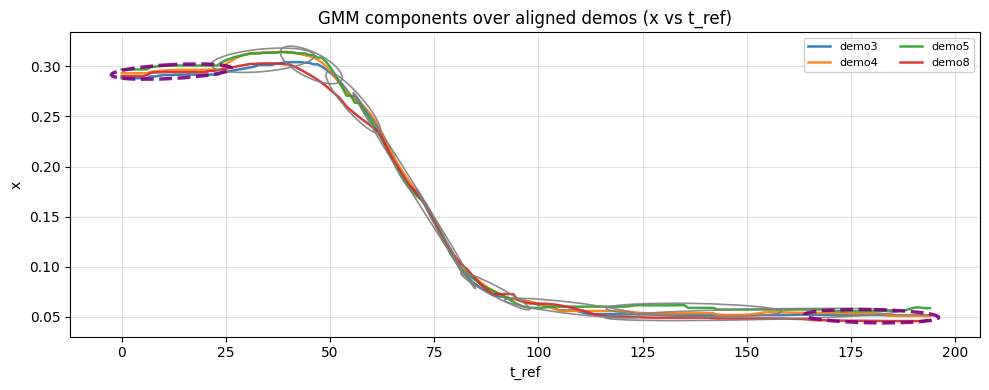

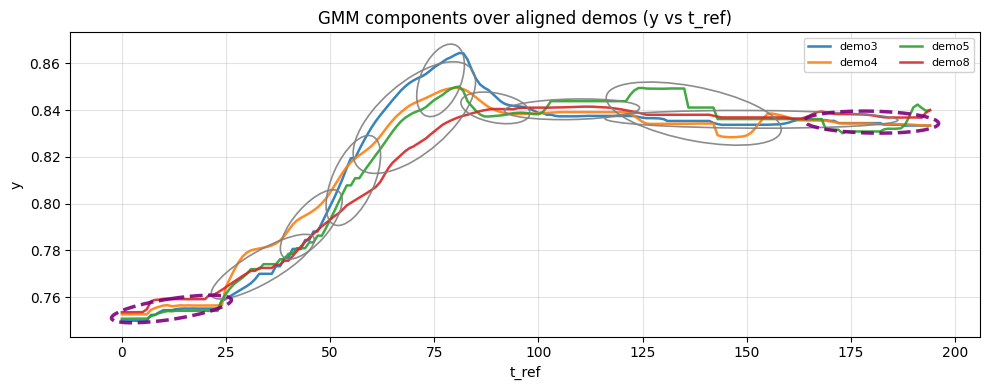

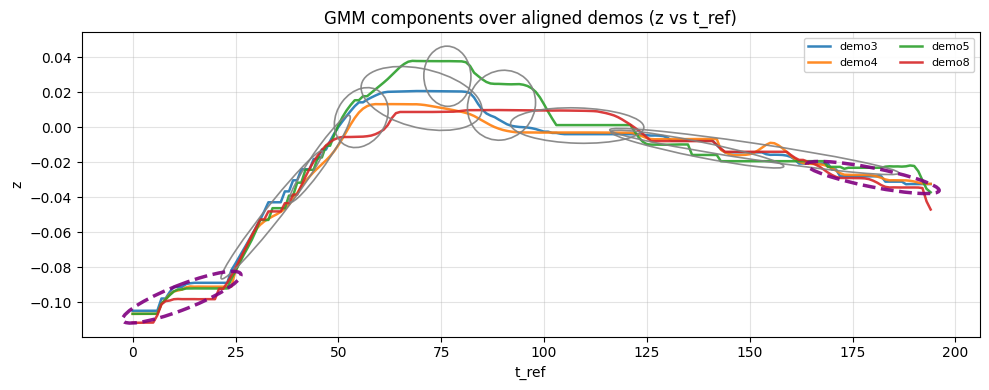

In [35]:
plot_gmm_highlights_time_series_xyz(gmm_df, gmm, scaler, value_col="x", time_col="t_ref")
plot_gmm_highlights_time_series_xyz(gmm_df, gmm, scaler, value_col="y", time_col="t_ref")
plot_gmm_highlights_time_series_xyz(gmm_df, gmm, scaler, value_col="z", time_col="t_ref")

### Piecewise

Test demos: [np.str_('demo3')]

GLOBAL results
  RMSE all: 0.0056277047751622485
  RMSE xyz: [0.00407957 0.00752897 0.00465671]


C:\Users\Jaxba\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Jaxba\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


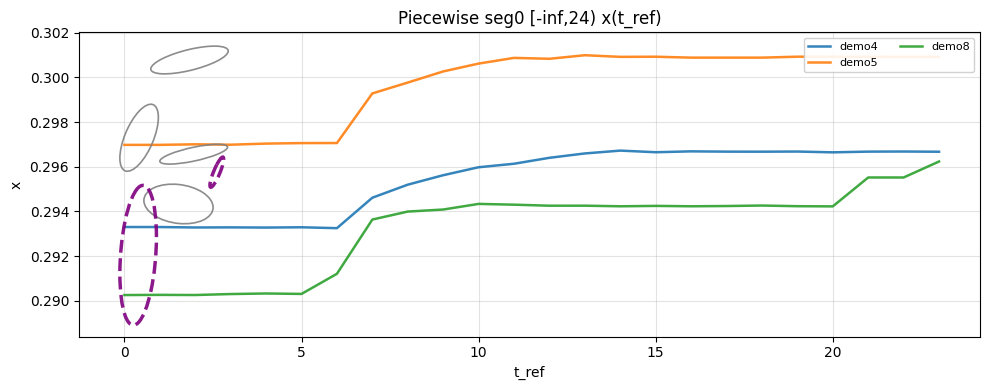

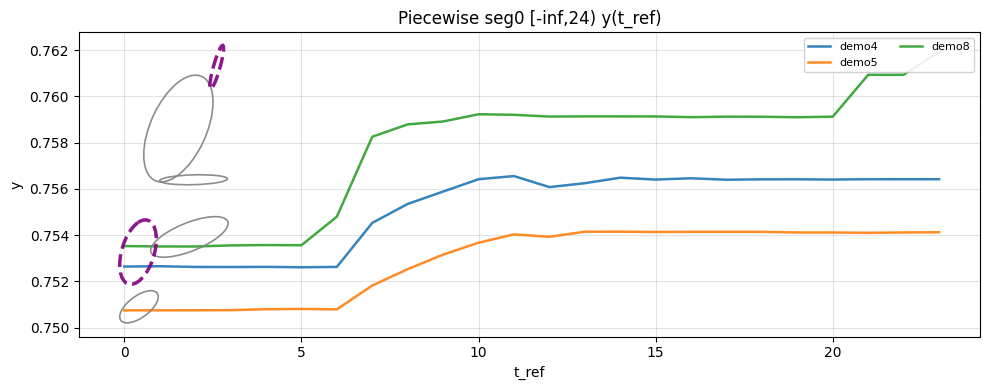

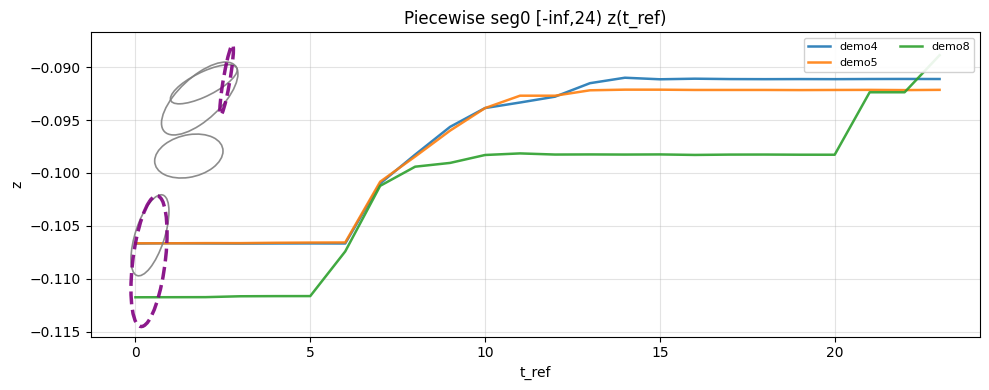

C:\Users\Jaxba\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


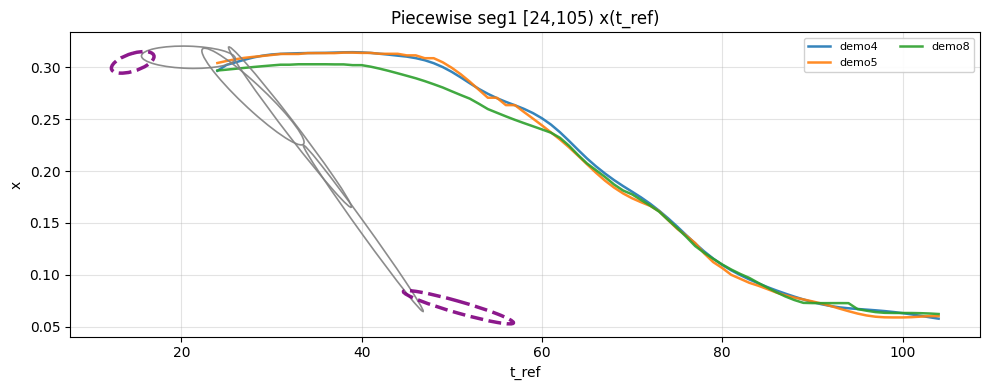

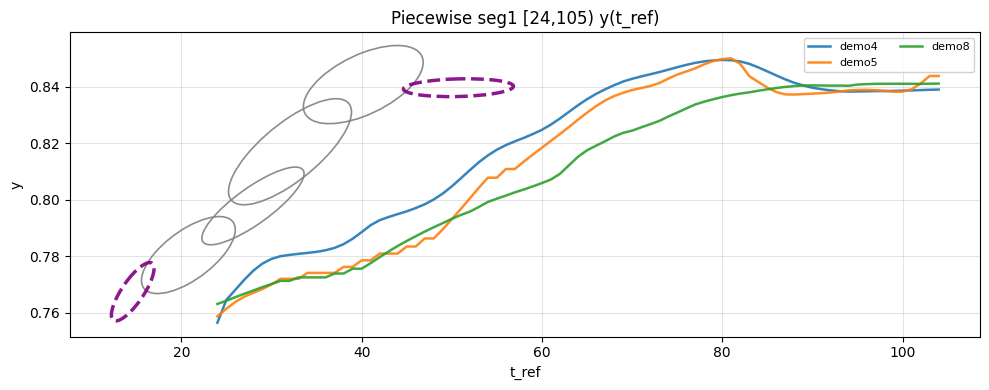

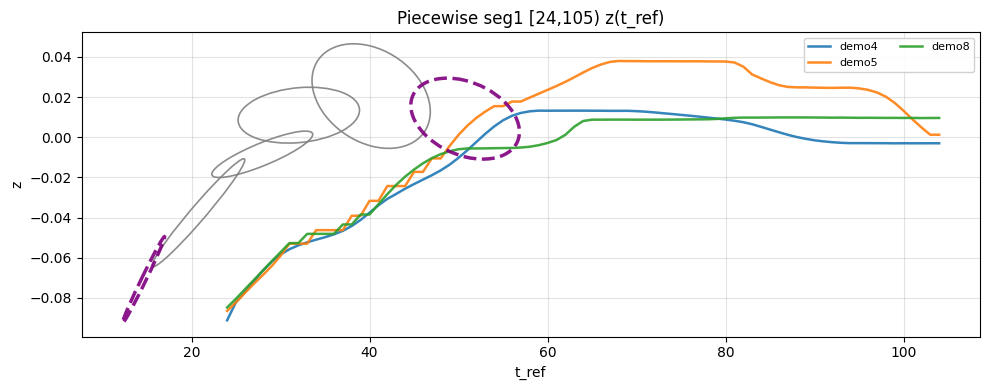

C:\Users\Jaxba\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


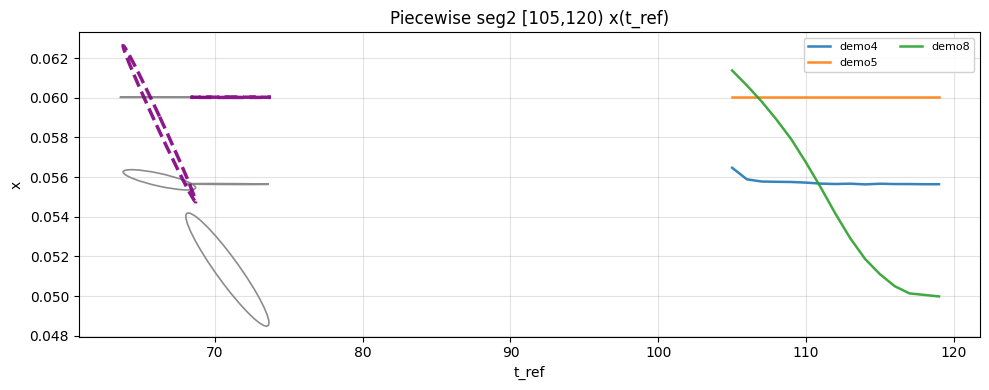

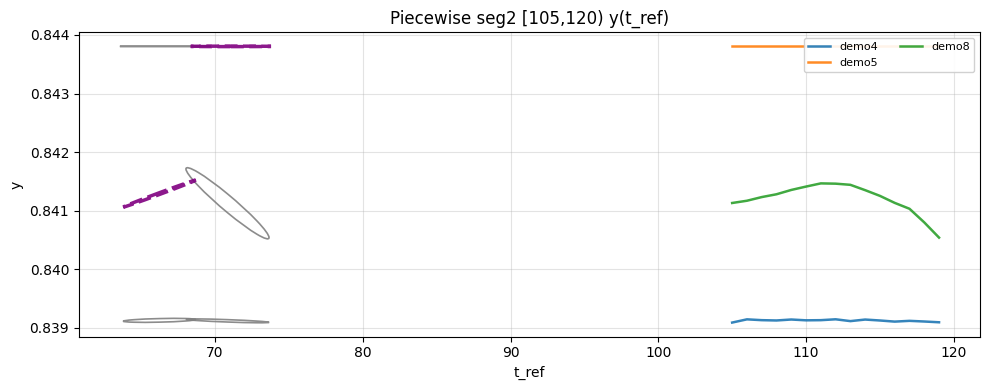

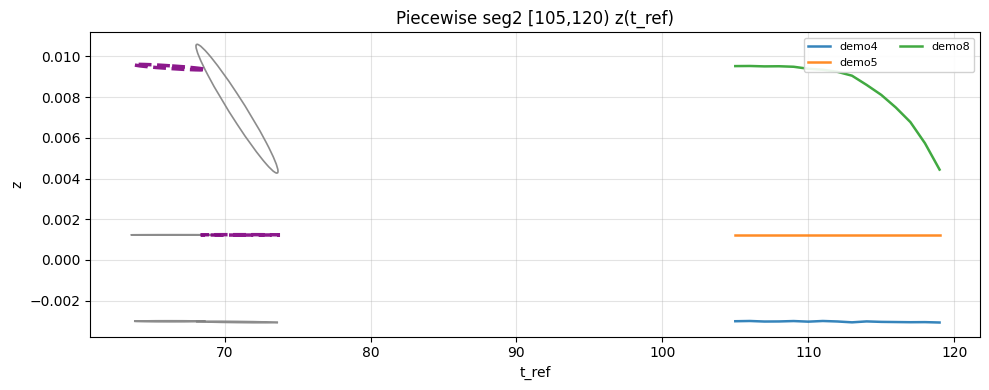

C:\Users\Jaxba\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1425: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


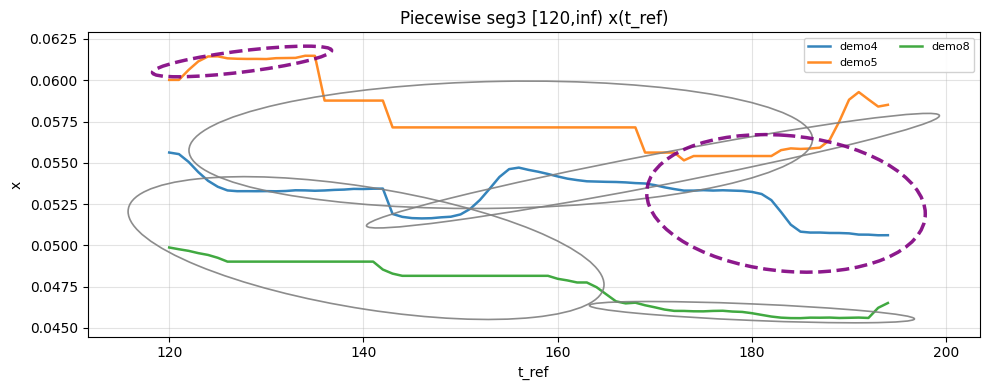

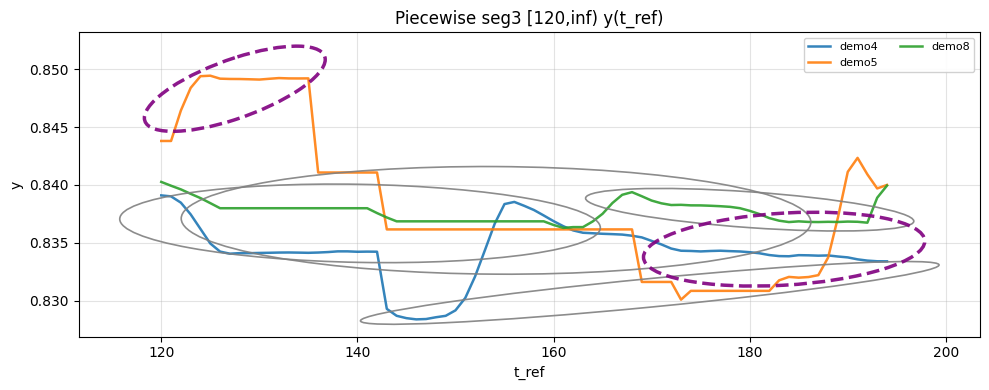

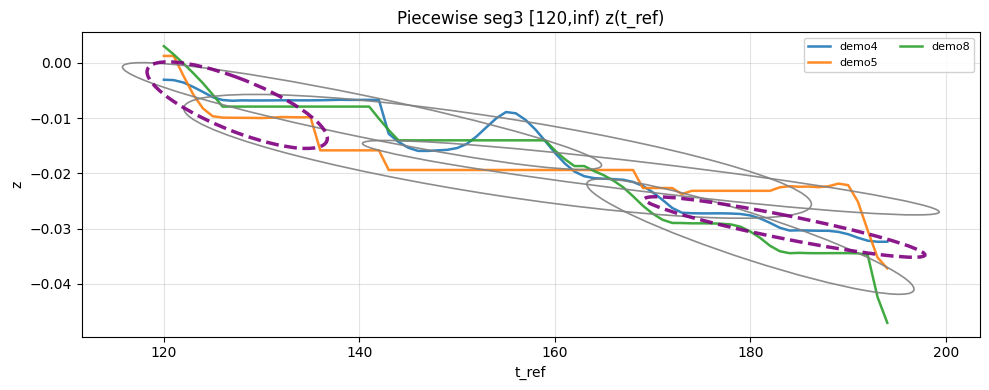


PIECEWISE results (splits at t_ref = 24, 105, 120)
  RMSE all: 0.0056194575576502875
  RMSE xyz: [0.00414645 0.00750861 0.00460029]

Winner by RMSE (lower is better): piecewise


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 0) Config: exact split points in t_ref
# -----------------------------
SPLITS = [24, 105, 120]               # exact split sample indices
BOUNDS = [None] + SPLITS + [None]     # [start, 24, 105, 120, end]
N_GLOBAL = 10
N_PIECE  = 6
SEED = 7
REG_COVAR = 1e-6

os.makedirs("figs", exist_ok=True)


# -----------------------------
# 1) Helpers
# -----------------------------
def add_t_norm_per_demo(df, time_col="t_ref", demo_col="demo_id"):
    """Adds t_norm in [0,1] per demo based on min/max of time_col."""
    out = df.copy()
    out["t_norm"] = np.nan
    for d in out[demo_col].unique():
        sub = out[out[demo_col] == d].sort_values(time_col)
        t = sub[time_col].to_numpy(dtype=float)
        t0, t1 = float(t.min()), float(t.max())
        out.loc[sub.index, "t_norm"] = 0.0 if np.isclose(t1, t0) else (t - t0) / (t1 - t0)
    return out


def split_by_tref(df, bounds, demo_col="demo_id", time_col="t_ref"):
    """
    bounds like [None, 24, 105, 120, None]
    creates segments:
      seg0: t_ref < 24
      seg1: 24 <= t_ref < 105
      seg2: 105 <= t_ref < 120
      seg3: t_ref >= 120
    """
    segs = []
    for i in range(len(bounds) - 1):
        a, b = bounds[i], bounds[i + 1]
        if a is None and b is None:
            mask = np.ones(len(df), dtype=bool)
        elif a is None:
            mask = df[time_col] < b
        elif b is None:
            mask = df[time_col] >= a
        else:
            mask = (df[time_col] >= a) & (df[time_col] < b)

        seg = df[mask].copy()
        seg["segment_id"] = i
        seg["segment_bounds"] = f"[{a if a is not None else '-inf'},{b if b is not None else 'inf'})"
        segs.append(seg)
    return segs


def train_test_split_by_demo(df, demo_col="demo_id", test_ratio=0.3, seed=7):
    rng = np.random.default_rng(seed)
    demos = np.array(sorted(df[demo_col].unique()))
    rng.shuffle(demos)
    n_test = max(1, int(round(len(demos) * test_ratio)))
    test_d = set(demos[:n_test])
    return (
        df[~df[demo_col].isin(test_d)].copy(),
        df[df[demo_col].isin(test_d)].copy(),
        sorted(list(test_d)),
    )


def fit_gmm(train_df, n_components, reg_covar=1e-6, seed=0):
    """Fit GMM on [t_norm, x, y, z]. Returns (gmm, scaler)."""
    X = train_df[["t_norm", "x", "y", "z"]].to_numpy(dtype=float)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type="full",
        reg_covar=reg_covar,
        random_state=seed,
        init_params="kmeans",
        max_iter=500,
    )
    gmm.fit(Xs)
    return gmm, scaler


def gmr_predict_xyz_from_tnorm(gmm, scaler, t_norm_query):
    """
    GMR: predict E[x,y,z | t_norm]. Assumes GMM trained on scaled [t_norm,x,y,z].
    Returns mu_xyz (T,3).
    """
    t_norm_query = np.asarray(t_norm_query, dtype=float).reshape(-1, 1)
    T = t_norm_query.shape[0]

    pi = gmm.weights_          # (K,)
    mu = gmm.means_            # (K,4)
    Sig = gmm.covariances_     # (K,4,4)
    K = gmm.n_components
    eps = 1e-10

    # scale t into model space
    t_scaled = (t_norm_query - scaler.mean_[0]) / scaler.scale_[0]  # (T,1)

    # ---- SAFE block slices (no np.ix_, no reshape) ----
    mu_t  = mu[:, 0:1]          # (K,1)
    mu_y  = mu[:, 1:4]          # (K,3)

    Sig_tt = Sig[:, 0:1, 0:1]   # (K,1,1)
    Sig_yt = Sig[:, 1:4, 0:1]   # (K,3,1)
    Sig_ty = Sig[:, 0:1, 1:4]   # (K,1,3)
    Sig_yy = Sig[:, 1:4, 1:4]   # (K,3,3)

    mu_y_all = np.zeros((T, 3), dtype=float)

    for i in range(T):
        t_i = t_scaled[i, 0]

        # log responsibilities over t (1D normal)
        logp = np.zeros(K)
        for k in range(K):
            s = Sig_tt[k, 0, 0] + eps
            dt = t_i - mu_t[k, 0]
            logp[k] = np.log(pi[k] + eps) - 0.5 * (np.log(2*np.pi*s) + (dt*dt)/s)

        logp -= np.max(logp)
        p = np.exp(logp)
        beta = p / (np.sum(p) + eps)

        # conditional mean
        mu_cond = np.zeros(3)
        for k in range(K):
            inv_Sigtt = 1.0 / (Sig_tt[k, 0, 0] + eps)
            dt = t_i - mu_t[k, 0]
            mu_k = mu_y[k] + (Sig_yt[k].reshape(3) * inv_Sigtt * dt)
            mu_cond += beta[k] * mu_k

        mu_y_all[i] = mu_cond

    # unscale xyz
    scales = scaler.scale_[1:4]   # x,y,z scales
    means  = scaler.mean_[1:4]    # x,y,z means
    mu_xyz = mu_y_all * scales + means
    return mu_xyz

def eval_rmse(test_df, predict_fn, demo_col="demo_id", time_col="t_ref"):
    errs = []
    for d in test_df[demo_col].unique():
        sub = test_df[test_df[demo_col] == d].sort_values(time_col)
        mu_hat = predict_fn(sub)
        gt = sub[["x", "y", "z"]].to_numpy(dtype=float)
        errs.append(mu_hat - gt)
    E = np.vstack(errs)
    rmse_xyz = np.sqrt(np.mean(E**2, axis=0))
    rmse_all = float(np.sqrt(np.mean(E**2)))
    return rmse_all, rmse_xyz


def safe_title_to_filename(s):
    return "".join(c if (c.isalnum() or c in "._-") else "_" for c in s)


# -----------------------------
# 2) Data checks
# -----------------------------
required = {"demo_id", "t_ref", "x", "y", "z"}
missing = required - set(gmm_df.columns)
if missing:
    raise ValueError(f"gmm_df missing columns: {missing}")

if "t_norm" not in gmm_df.columns:
    gmm_df = add_t_norm_per_demo(gmm_df)

# -----------------------------
# 3) Train/test split by demo
# -----------------------------
train_df, test_df, test_demos = train_test_split_by_demo(gmm_df, test_ratio=0.3, seed=SEED)
print("Test demos:", test_demos)

# -----------------------------
# 4) GLOBAL model
# -----------------------------
gmm_global, scaler_global = fit_gmm(train_df, N_GLOBAL, reg_covar=REG_COVAR, seed=SEED)

def predict_global(sub_df):
    t = sub_df["t_norm"].to_numpy(dtype=float)
    return gmr_predict_xyz_from_tnorm(gmm_global, scaler_global, t)

rmse_g_all, rmse_g_xyz = eval_rmse(test_df, predict_global)
print("\nGLOBAL results")
print("  RMSE all:", rmse_g_all)
print("  RMSE xyz:", rmse_g_xyz)

# -----------------------------
# 5) PIECEWISE models (exact t_ref splits)
# -----------------------------
train_segs = split_by_tref(train_df, BOUNDS)
test_segs  = split_by_tref(test_df,  BOUNDS)

piece_models = []
for seg in train_segs:
    seg_id = int(seg["segment_id"].iloc[0])
    bounds_str = seg["segment_bounds"].iloc[0]

    if len(seg) < 30:
        raise ValueError(f"Segment {seg_id} {bounds_str} too small ({len(seg)} rows). Adjust splits.")

    gmm_k, scaler_k = fit_gmm(seg, N_PIECE, reg_covar=REG_COVAR, seed=SEED + seg_id)
    piece_models.append((gmm_k, scaler_k, bounds_str))

    # ---- Piecewise RESULTS PLOTS (x,y,z vs t_ref) ----
    # Uses YOUR plotting function; we just force unique filenames by temporarily
    # changing title to include segment info.
    for val in ["x", "y", "z"]:
        title = f"Piecewise seg{seg_id} {bounds_str} {val}(t_ref)"
        plot_gmm_highlights_time_series_xyz(
            gmm_df=seg,
            gmm=gmm_k,
            scaler=scaler_k,
            value_col=val,
            time_col="t_ref",
            n_std=2.0,
            max_components=None,
            highlight="time_extremes",
            title=title,
        )
        # your function currently saves figs/{ylab}-GMM.pdf; it will overwrite.
        # If you don't want overwriting, edit the save line inside it.
        # For a notebook-only run, you can comment out plt.savefig inside your function.

# prediction that chooses the correct segment model based on t_ref
def predict_piecewise(sub_df):
    sub = sub_df.sort_values("t_ref").copy()
    t_ref = sub["t_ref"].to_numpy(dtype=float)
    t_norm = sub["t_norm"].to_numpy(dtype=float)

    mu_hat = np.zeros((len(sub), 3), dtype=float)

    # segment masks by exact boundaries
    # seg0: t_ref < 24
    # seg1: 24 <= t_ref < 105
    # seg2: 105 <= t_ref < 120
    # seg3: t_ref >= 120
    masks = [
        (t_ref < SPLITS[0]),
        (t_ref >= SPLITS[0]) & (t_ref < SPLITS[1]),
        (t_ref >= SPLITS[1]) & (t_ref < SPLITS[2]),
        (t_ref >= SPLITS[2]),
    ]

    for seg_id, mask in enumerate(masks):
        if not np.any(mask):
            continue
        gmm_k, scaler_k, _ = piece_models[seg_id]
        mu_hat[mask] = gmr_predict_xyz_from_tnorm(gmm_k, scaler_k, t_norm[mask])

    return mu_hat

rmse_p_all, rmse_p_xyz = eval_rmse(test_df, predict_piecewise)
print("\nPIECEWISE results (splits at t_ref = 24, 105, 120)")
print("  RMSE all:", rmse_p_all)
print("  RMSE xyz:", rmse_p_xyz)

print("\nWinner by RMSE (lower is better):",
      "piecewise" if rmse_p_all < rmse_g_all else "global")

### GMR

In [37]:
import numpy as np

def gmr_predict_xyz_from_sklearn(gmm, scaler, t_query_raw):
    """
    Given a sklearn GaussianMixture fit on scaled features [t_norm, x, y, z],
    return:
      mu_xyz_raw:  (T, 3) mean of (x,y,z) conditioned on time
      cov_xyz_raw: (T, 3, 3) covariance of (x,y,z) conditioned on time

    Notes:
    - Assumes gmm.covariance_type == "full"
    - Assumes scaler is a StandardScaler fit on [t_norm, x, y, z]
    """

    # ---- GMM params in scaled space ----
    K = gmm.n_components
    priors = gmm.weights_            # (K,)
    means  = gmm.means_              # (K,4) in scaled space
    covs   = gmm.covariances_        # (K,4,4) in scaled space (full)

    # ---- scaler params ----
    mean_raw  = scaler.mean_         # (4,)
    scale_raw = scaler.scale_        # (4,)

    # ---- raw t_query -> scaled t_query ----
    t_query_raw = np.asarray(t_query_raw, dtype=float).ravel()
    t_scaled = (t_query_raw - mean_raw[0]) / scale_raw[0]

    mu_xyz_raw  = np.zeros((len(t_scaled), 3), dtype=float)
    cov_xyz_raw = np.zeros((len(t_scaled), 3, 3), dtype=float)

    for n, tq in enumerate(t_scaled):
        # For each component, compute conditional Gaussian of xyz given t=tq
        comp_mu = np.zeros((K, 3), dtype=float)     # (K,3)
        comp_S  = np.zeros((K, 3, 3), dtype=float)  # (K,3,3)
        beta    = np.zeros(K, dtype=float)          # unnormalized responsibilities at tq

        for k in range(K):
            mu_k = means[k]      # (4,)
            S_k  = covs[k]       # (4,4)

            mu_t     = mu_k[0]        # scalar
            mu_xyz_k = mu_k[1:4]      # (3,)

            S_tt = S_k[0, 0]          # scalar
            S_xt = S_k[1:4, 0]        # (3,)
            S_tx = S_k[0, 1:4]        # (3,)
            S_xx = S_k[1:4, 1:4]      # (3,3)

            # ---- conditional mean/cov in scaled space ----
            var_t = max(S_tt, 1e-12)
            inv_var_t = 1.0 / var_t
            dt = (tq - mu_t)

            # mu_xyz|t = mu_xyz + S_xt * inv(S_tt) * (t - mu_t)
            cond_mu = mu_xyz_k + S_xt * inv_var_t * dt

            # S_xyz|t = S_xx - S_xt * inv(S_tt) * S_tx
            cond_S  = S_xx - np.outer(S_xt, S_tx) * inv_var_t

            comp_mu[k] = cond_mu
            comp_S[k]  = cond_S

            # ---- likelihood of tq under component k (1D Gaussian in scaled space) ----
            norm = 1.0 / np.sqrt(2.0 * np.pi * var_t)
            like = norm * np.exp(-0.5 * (dt * dt) * inv_var_t)
            beta[k] = priors[k] * like

        # ---- normalize responsibilities ----
        s = beta.sum()
        if s < 1e-18:
            h = np.ones(K, dtype=float) / K
        else:
            h = beta / s

        # ---- mixture conditional mean in scaled space ----
        mu_mix = (h[:, None] * comp_mu).sum(axis=0)  # (3,)

        # ---- mixture conditional covariance in scaled space ----
        S_mix = np.zeros((3, 3), dtype=float)
        for k in range(K):
            diff = (comp_mu[k] - mu_mix).reshape(3, 1)
            S_mix += h[k] * (comp_S[k] + diff @ diff.T)

        # ---- unscale xyz mean/cov back to raw space ----
        # raw_xyz = scaled_xyz * scale_xyz + mean_xyz
        mu_raw = mu_mix * scale_raw[1:4] + mean_raw[1:4]

        A = np.diag(scale_raw[1:4])   # scaling matrix for (x,y,z)
        S_raw = A @ S_mix @ A         # covariance scaling

        mu_xyz_raw[n]  = mu_raw
        cov_xyz_raw[n] = S_raw

    return mu_xyz_raw, cov_xyz_raw


# ---- Query time grid ----
tq = np.linspace(0.0, 1.0, 200)   # (T,)
mu_xyz, cov_xyz = gmr_predict_xyz_from_sklearn(gmm, scaler, tq)

print("mu_xyz shape:", mu_xyz.shape)     # (200, 3)
print("cov_xyz shape:", cov_xyz.shape)   # (200, 3, 3)


mu_xyz shape: (200, 3)
cov_xyz shape: (200, 3, 3)


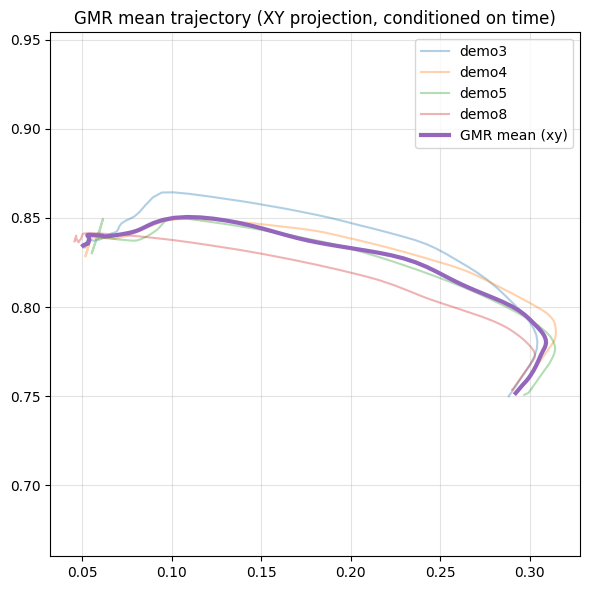

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

# plot aligned demos (optional)
for d in gmm_df["demo_id"].unique():
    sub = gmm_df[gmm_df["demo_id"] == d].sort_values("t_ref")
    plt.plot(sub["x"], sub["y"], alpha=0.35, linewidth=1.5, label=str(d))

# plot GMR mean (XY projection)
plt.plot(mu_xyz[:, 0], mu_xyz[:, 1], linewidth=3, label="GMR mean (xy)")

plt.axis("equal")
plt.grid(True, alpha=0.35)
plt.legend()
plt.title("GMR mean trajectory (XY projection, conditioned on time)")
plt.tight_layout()
plt.savefig("figs/xy-GMR.pdf")
plt.show()


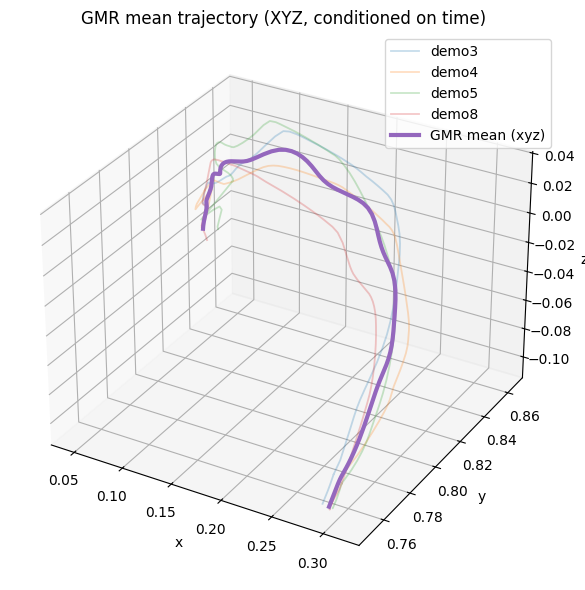

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection="3d")

# demos
for d in gmm_df["demo_id"].unique():
    sub = gmm_df[gmm_df["demo_id"] == d].sort_values("t_ref")
    ax.plot(sub["x"], sub["y"], sub["z"], alpha=0.25, linewidth=1.3, label=str(d))

# GMR mean
ax.plot(mu_xyz[:, 0], mu_xyz[:, 1], mu_xyz[:, 2], linewidth=3, label="GMR mean (xyz)")

ax.set_title("GMR mean trajectory (XYZ, conditioned on time)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
plt.tight_layout()
plt.savefig("figs/GMR.pdf")
plt.show()


In [40]:
import numpy as np
import pandas as pd

# Extract standard deviations from diagonal of covariance
std_x = np.sqrt(np.maximum(cov_xyz[:, 0, 0], 1e-12))
std_y = np.sqrt(np.maximum(cov_xyz[:, 1, 1], 1e-12))
std_z = np.sqrt(np.maximum(cov_xyz[:, 2, 2], 1e-12))

gmr_plot_df = pd.DataFrame({
    "t": tq,
    "x_mean": mu_xyz[:, 0],
    "y_mean": mu_xyz[:, 1],
    "z_mean": mu_xyz[:, 2],
    "x_std": std_x,
    "y_std": std_y,
    "z_std": std_z,
})
display(gmr_plot_df.head())


t    x_mean    y_mean    z_mean     x_std     y_std     z_std
0  0.000000  0.292182  0.751698 -0.107686  0.003455  0.002222  0.003772
1  0.005025  0.292400  0.751960 -0.106826  0.003455  0.002222  0.003772
2  0.010050  0.292618  0.752223 -0.105966  0.003455  0.002222  0.003772
3  0.015075  0.292836  0.752485 -0.105105  0.003455  0.002222  0.003772
4  0.020101  0.293054  0.752748 -0.104245  0.003455  0.002222  0.003773

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk")

def plot_mean_with_band(df, t_col, mean_col, std_col, label, title, ylabel, n_sigma=2.0):
    plt.figure(figsize=(9, 4))

    sns.lineplot(
        data=df,
        x=t_col,
        y=mean_col,
        linewidth=3,
        label=label
    )

    plt.fill_between(
        df[t_col],
        df[mean_col] - n_sigma * df[std_col],
        df[mean_col] + n_sigma * df[std_col],
        alpha=0.3,
        label=f"±{n_sigma:g}σ"
    )

    plt.xlabel("Normalized Time")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figs/{mean_col}-GMR.pdf")
    plt.show()


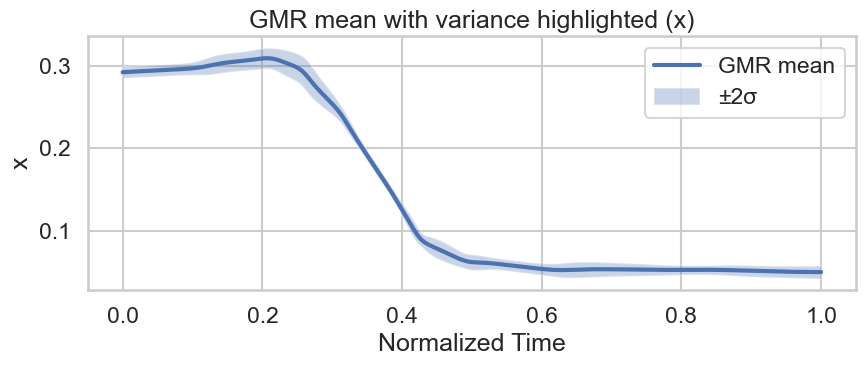

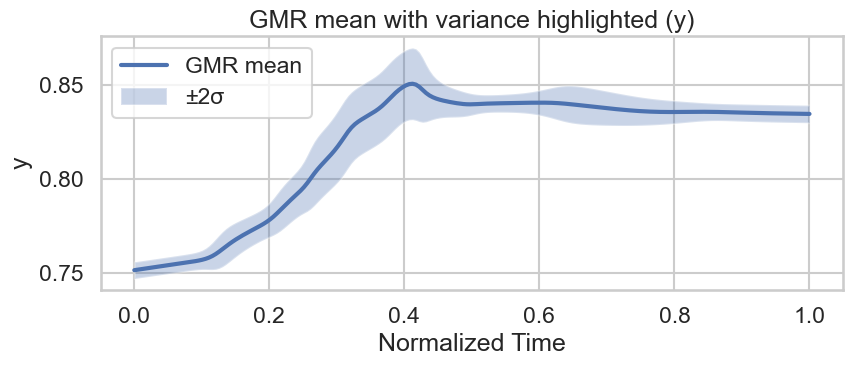

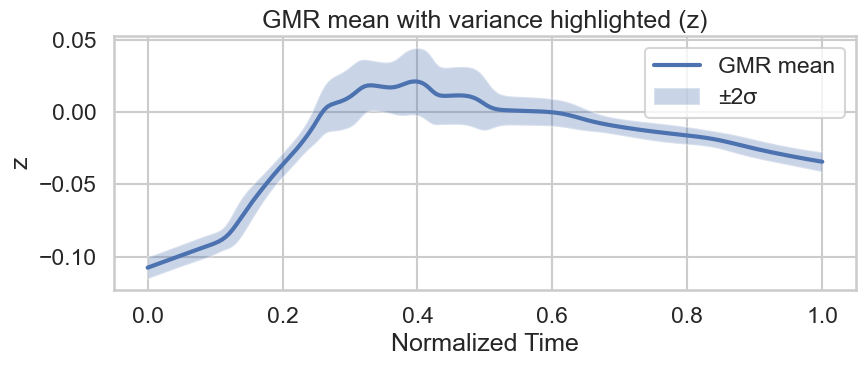

In [42]:
plot_mean_with_band(
    gmr_plot_df, "t", "x_mean", "x_std",
    label="GMR mean", title="GMR mean with variance highlighted (x)", ylabel="x"
)

plot_mean_with_band(
    gmr_plot_df, "t", "y_mean", "y_std",
    label="GMR mean", title="GMR mean with variance highlighted (y)", ylabel="y"
)

plot_mean_with_band(
    gmr_plot_df, "t", "z_mean", "z_std",
    label="GMR mean", title="GMR mean with variance highlighted (z)", ylabel="z"
)


## Part E. Obstacle Avoidance

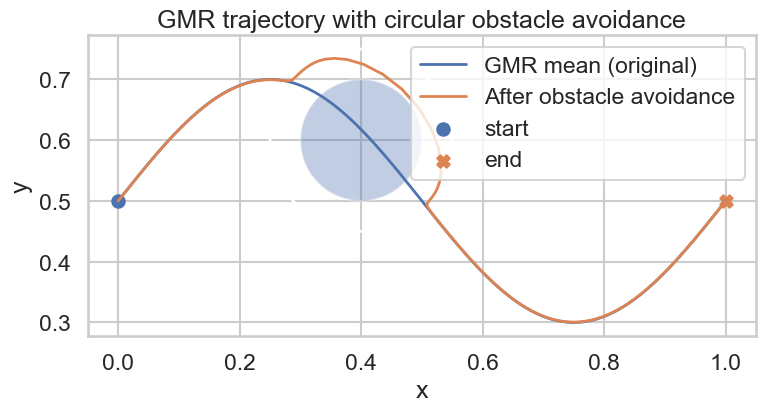

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def avoid_obstacle_push_and_smooth(mu_xy, center, radius, margin=0.05, smooth_passes=5):
    """
    mu_xy: (T,2) array of GMR mean positions over time
    center: (2,) obstacle center
    radius: obstacle radius
    margin: safety buffer
    smooth_passes: smoothing iterations
    """
    mu = mu_xy.copy()
    c = np.array(center, dtype=float)
    R = float(radius + margin)

    # --- 1) push-out step (project points inside inflated obstacle to boundary) ---
    for i in range(len(mu)):
        v = mu[i] - c
        d = np.linalg.norm(v) + 1e-12
        if d < R:
            mu[i] = c + (R * v / d)

    # --- 2) smooth while keeping endpoints fixed ---
    for _ in range(smooth_passes):
        mu_new = mu.copy()
        mu_new[1:-1] = 0.25 * mu[:-2] + 0.5 * mu[1:-1] + 0.25 * mu[2:]
        mu_new[0] = mu[0]
        mu_new[-1] = mu[-1]
        mu = mu_new

    return mu

# -------------------------
# Example: CALL + PLOT
# -------------------------

# 1) Put your GMR mean trajectory here
# If you already have arrays mu_x, mu_y:
# mu_xy = np.column_stack([mu_x, mu_y])

# For demo purposes, here's a fake smooth trajectory (replace this with yours!)
T = 200
tt = np.linspace(0, 1, T)
mu_xy = np.column_stack([
    tt,
    0.5 + 0.2*np.sin(2*np.pi*tt)
])

# 2) Define the obstacle
obs_center = (0.4, 0.6)
obs_radius = 0.10
safety_margin = 0.05

# 3) Compute the avoiding path
mu_avoid = avoid_obstacle_push_and_smooth(
    mu_xy,
    center=obs_center,
    radius=obs_radius,
    margin=safety_margin,
    smooth_passes=10
)

# 4) Plot obstacle + both paths
fig, ax = plt.subplots(figsize=(8, 6))

# Original GMR path
ax.plot(mu_xy[:, 0], mu_xy[:, 1], linewidth=2, label="GMR mean (original)")

# Avoiding path
ax.plot(mu_avoid[:, 0], mu_avoid[:, 1], linewidth=2, label="After obstacle avoidance")

# Mark start/end for clarity
ax.scatter(mu_xy[0, 0],  mu_xy[0, 1],  s=80, marker="o", label="start")
ax.scatter(mu_xy[-1, 0], mu_xy[-1, 1], s=80, marker="X", label="end")

# Obstacle (filled)
obs = plt.Circle(obs_center, obs_radius, fill=True, alpha=0.35)
ax.add_patch(obs)

# Safety margin (outline)
inflated = plt.Circle(obs_center, obs_radius + safety_margin, fill=False, linewidth=2)
ax.add_patch(inflated)

# Make the geometry readable
ax.set_aspect("equal", adjustable="box")
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("GMR trajectory with circular obstacle avoidance")
ax.legend()
plt.tight_layout()
plt.savefig("figs/AvoidanceExample.pdf")
plt.show()


AttributeError: module 'matplotlib.pyplot' has no attribute 'savefif'

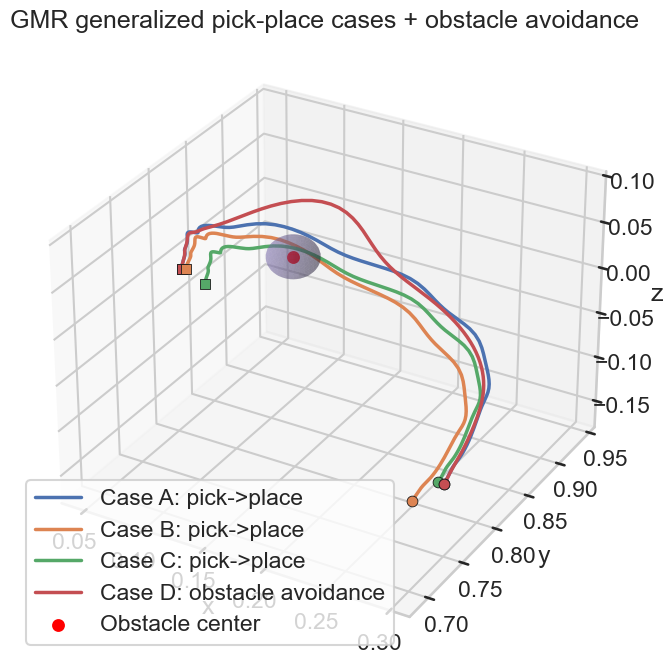

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ------------------------------------------------------------
# 0) You already have this from earlier:
#    mu_xyz, cov_xyz = gmr_predict_xyz_from_sklearn(gmm, scaler, tq)
# ------------------------------------------------------------

# ----------------------------
# Helper: safe normalize
# ----------------------------
def _unit(v, eps=1e-12):
    n = np.linalg.norm(v)
    return v / max(n, eps)

# ------------------------------------------------------------
# 1) Rotation matrix mapping vector a -> b (Rodrigues)
# ------------------------------------------------------------
def rotation_matrix_from_vectors(a, b):
    """
    Returns R such that R @ a ~= b for 3D vectors a,b
    Handles parallel and anti-parallel cases.
    """
    a_u = _unit(a)
    b_u = _unit(b)

    v = np.cross(a_u, b_u)
    c = np.dot(a_u, b_u)  # cos(theta)
    s = np.linalg.norm(v)

    # If vectors are almost identical
    if s < 1e-10 and c > 0:
        return np.eye(3)

    # If vectors are opposite
    if s < 1e-10 and c < 0:
        # pick an arbitrary axis orthogonal to a
        axis = np.array([1.0, 0.0, 0.0])
        if abs(a_u[0]) > 0.9:
            axis = np.array([0.0, 1.0, 0.0])
        axis = _unit(np.cross(a_u, axis))
        # 180 deg rotation: R = I + 2*K^2 where K is skew(axis)
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        return np.eye(3) + 2 * (K @ K)

    # General Rodrigues formula
    K = np.array([[0, -v[2], v[1]],
                  [v[2], 0, -v[0]],
                  [-v[1], v[0], 0]])
    R = np.eye(3) + K + (K @ K) * ((1 - c) / (s**2))
    return R

# ------------------------------------------------------------
# 2) Generalize trajectory to new start/goal (pick/place)
#    - Takes nominal GMR mean mu(t)
#    - Applies rigid rotation + uniform scale about start
#    - Ensures endpoints match exactly
# ------------------------------------------------------------
def warp_to_start_goal(mu_xyz, start_xyz, goal_xyz):
    """
    mu_xyz: (T,3) nominal mean trajectory (original demo space)
    start_xyz, goal_xyz: (3,) desired start and goal

    Returns: traj (T,3) warped trajectory
    """
    T = mu_xyz.shape[0]
    p0 = mu_xyz[0].copy()
    pT = mu_xyz[-1].copy()

    d0 = pT - p0
    d1 = goal_xyz - start_xyz

    # rotation mapping original displacement to new displacement
    R = rotation_matrix_from_vectors(d0, d1)

    # uniform scaling to match displacement magnitudes
    s = np.linalg.norm(d1) / max(np.linalg.norm(d0), 1e-12)

    # apply transform about p0, then translate to start_xyz
    traj = start_xyz + ( (mu_xyz - p0) @ R.T ) * s

    # enforce exact endpoints (numerical safety)
    traj[0]  = start_xyz
    traj[-1] = goal_xyz
    return traj

# ------------------------------------------------------------
# 3) Obstacle avoidance deformation
#    - Repulsive force from spherical obstacle
#    - Weighted by "flexibility" from GMR covariance:
#         high variance -> allow more deviation
#         low variance  -> resist deviation
#    - Plus smoothing via Laplacian to keep it nice
# ------------------------------------------------------------
def avoid_sphere_obstacle(
    traj,
    cov_xyz,
    center,
    radius,
    influence=0.20,
    step=0.08,
    iters=80,
    smooth_w=0.15,
):
    """
    traj: (T,3) initial trajectory (already start/goal matched)
    cov_xyz: (T,3,3) from GMR (raw space)
    center: (3,) obstacle center
    radius: scalar obstacle radius
    influence: distance outside radius where repulsion acts (meters or your unit)
    step: gradient step size
    iters: iterations of deformation
    smooth_w: smoothing weight (0..1)

    Returns: deformed trajectory (T,3)
    """
    T = traj.shape[0]
    X = traj.copy()

    # flexibility weight from covariance (trace is a simple “overall variance”)
    flex = np.trace(cov_xyz, axis1=1, axis2=2)  # (T,)
    flex = flex / max(np.max(flex), 1e-12)      # normalize to 0..1

    c = np.asarray(center, dtype=float).reshape(3,)
    r = float(radius)
    d0 = float(influence)

    def laplacian_smooth(Y):
        # simple second-difference smoothing
        Z = Y.copy()
        for i in range(1, T-1):
            Z[i] = Y[i] + smooth_w * (Y[i-1] - 2*Y[i] + Y[i+1])
        Z[0] = Y[0]
        Z[-1] = Y[-1]
        return Z

    for _ in range(iters):
        grad = np.zeros_like(X)

        # obstacle repulsion gradient
        for i in range(1, T-1):  # keep endpoints fixed
            p = X[i]
            v = p - c
            dist = np.linalg.norm(v)

            # inside influence zone: dist < r + d0
            if dist < r + d0:
                # push direction away from obstacle
                dir_away = _unit(v)

                # potential that grows as you approach the obstacle boundary
                # (smoothly goes to 0 at dist = r + d0)
                # magnitude ~ (1/(dist-r) - 1/d0)
                gap = max(dist - r, 1e-6)
                mag = (1.0 / gap - 1.0 / d0)

                # weight by flexibility: if flex small, reduce deviation
                # use (0.2 + flex) so even low-flex regions can move a bit if necessary
                w = 0.2 + flex[i]

                grad[i] += w * mag * dir_away

        # gradient step
        axis_gain = np.array([1.0, 1.0, 0.08])  # reduce z updates for proportional axes
        X[1:-1] += step * (grad[1:-1] * axis_gain)

        # smoothing pass to remove sharp bends
        X = laplacian_smooth(X)

        # re-enforce endpoints
        X[0] = traj[0]
        X[-1] = traj[-1]

    return X

# ------------------------------------------------------------
# 4) Plotting utilities
# ------------------------------------------------------------
def plot_cases_3d(cases, obstacle=None, title="Pick & Place Trajectory Cases"):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    all_pts = []

    # ---- plot trajectories + colored endpoints ----
    for case in cases:
        X = case["traj"]

        # plot line and capture color
        (line,) = ax.plot(
            X[:, 0], X[:, 1], X[:, 2],
            linewidth=2.5,
            label=case["name"]
        )
        color = line.get_color()

        # start = circle (same color)
        ax.scatter(
            X[0, 0], X[0, 1], X[0, 2],
            s=60, marker="o",
            color=color,
            edgecolor="k",
            linewidth=0.6,
            zorder=5
        )

        # end = square (same color)
        ax.scatter(
            X[-1, 0], X[-1, 1], X[-1, 2],
            s=60, marker="s",
            color=color,
            edgecolor="k",
            linewidth=0.6,
            zorder=5
        )

        all_pts.append(X)

    # ---- draw obstacle ----
    if obstacle is not None:
        c = np.asarray(obstacle["center"], dtype=float)
        r = float(obstacle["radius"])
        d0 = float(obstacle.get("influence", 0.0))

        u = np.linspace(0, 2*np.pi, 32)
        v = np.linspace(0, np.pi, 16)

        xs = c[0] + r * np.outer(np.cos(u), np.sin(v))
        ys = c[1] + r * np.outer(np.sin(u), np.sin(v))
        zs = c[2] + r * np.outer(np.ones_like(u), np.cos(v))
        ax.plot_surface(xs, ys, zs, alpha=0.35, linewidth=0)

        if d0 > 0:
            xs2 = c[0] + (r + d0) * np.outer(np.cos(u), np.sin(v))
            ys2 = c[1] + (r + d0) * np.outer(np.sin(u), np.sin(v))
            zs2 = c[2] + (r + d0) * np.outer(np.ones_like(u), np.cos(v))
            ax.plot_wireframe(xs2, ys2, zs2, alpha=0.35, linewidth=0.8)

        ax.scatter(c[0], c[1], c[2], s=60, color="red", label="Obstacle center")
        all_pts.append(c.reshape(1, 3))

    # ---- FORCE EQUAL AXIS SCALE ----
    P = np.vstack(all_pts)
    mins = P.min(axis=0)
    maxs = P.max(axis=0)
    max_range = (maxs - mins).max()
    center = 0.5 * (maxs + mins)

    ax.set_xlim(center[0] - max_range/2, center[0] + max_range/2)
    ax.set_ylim(center[1] - max_range/2, center[1] + max_range/2)
    ax.set_zlim(center[2] - max_range/2, center[2] + max_range/2)

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.legend()
    plt.tight_layout()
    plt.savefif("ObstacleAvoidance.pdf")
    plt.show()


def plot_xy_projection(traj, obstacle=None, title="XY projection"):
    plt.figure(figsize=(6, 6))

    # plot trajectory and capture color
    (line,) = plt.plot(traj[:, 0], traj[:, 1], linewidth=3, label="trajectory")
    color = line.get_color()

    # start = circle
    plt.scatter(
        traj[0, 0], traj[0, 1],
        s=80, marker="o",
        color=color,
        edgecolor="k",
        linewidth=0.6,
        label="start",
        zorder=5
    )

    # end = square
    plt.scatter(
        traj[-1, 0], traj[-1, 1],
        s=80, marker="s",
        color=color,
        edgecolor="k",
        linewidth=0.6,
        label="goal",
        zorder=5
    )

    # obstacle
    if obstacle is not None:
        c = np.asarray(obstacle["center"], dtype=float)
        r = float(obstacle["radius"])

        plt.gca().add_patch(
            plt.Circle((c[0], c[1]), r, color="red", alpha=0.45, label="Obstacle")
        )

        plt.gca().add_patch(
            plt.Circle(
                (c[0], c[1]),
                r * 1.8,
                fill=False,
                linestyle="--",
                linewidth=2.5,
                edgecolor="red",
                alpha=0.9,
                zorder=4,
                label="Obstacle influence"
            )
        )

    plt.axis("equal")
    plt.grid(True, alpha=0.35)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 5) Build 3 pick/place cases + 1 obstacle avoidance case
# ------------------------------------------------------------
# Query GMR once (nominal, in the demo’s “canonical” space)
tq = np.linspace(0.0, 1.0, 200)
mu_xyz, cov_xyz = gmr_predict_xyz_from_sklearn(gmm, scaler, tq)

# Define 3 different pick/place pairs
cases_cfg = [
    {"name": "Case A: pick->place", "pick": np.array([0.3, 0.75, -0.1]), "place": np.array([0.03, 0.84, -0.03])},
    {"name": "Case B: pick->place", "pick": np.array([0.28, 0.74, -0.12]), "place": np.array([0.04, 0.83, -0.02])},
    {"name": "Case C: pick->place", "pick": np.array([0.29, 0.76, -0.11]), "place": np.array([0.05, 0.84, -0.04])},
]

# Generate generalized trajectories
cases = []
for cfg in cases_cfg:
    traj = warp_to_start_goal(mu_xyz, cfg["pick"], cfg["place"])
    cases.append({"name": cfg["name"], "traj": traj})

# Obstacle avoidance case (start/goal based on Case A, but with obstacle)
obstacle = {"center": np.array([0.12, 0.85, 0.01]), "radius": 0.02}

traj_nominal = warp_to_start_goal(mu_xyz, cases_cfg[0]["pick"], cases_cfg[0]["place"])
traj_avoid = avoid_sphere_obstacle(
    traj_nominal,
    cov_xyz=cov_xyz,
    center=obstacle["center"],
    radius=obstacle["radius"],
    influence=0.01,   # how far out repulsion acts
    step=0.01,        # deformation step size
    iters=90,         # iterations
    smooth_w=0.18,    # smoothing strength
)

cases_with_avoid = cases + [{"name": "Case D: obstacle avoidance", "traj": traj_avoid}]

# ------------------------------------------------------------
# 6) Plot all cases in 3D + show obstacle
# ------------------------------------------------------------
plot_cases_3d(cases_with_avoid, obstacle=obstacle, title="GMR generalized pick-place cases + obstacle avoidance")

# Optional: focus on the avoidance case (XY projection)
plot_xy_projection(traj_nominal, obstacle=obstacle, title="Nominal (no avoidance) – XY projection")
plot_xy_projection(traj_avoid, obstacle=obstacle, title="With obstacle avoidance – XY projection")
